# ECG Delineator

In [1]:
import tensorflow as tf
from keras.models import Model
# from keras.applications import Xception
from keras.layers import Input, Dense, Flatten, Conv1D
from keras.utils import multi_gpu_model
import numpy as np

num_samples = 100
# height = 32
width = 32
num_classes = 1

# Instantiate the base model (or "template" model).
# We recommend doing this with under a CPU device scope,
# so that the model's weights are hosted on CPU memory.
# Otherwise they may end up hosted on a GPU, which would
# complicate weight sharing.
with tf.device('/cpu:0'):
    inpt = Input(shape=(width, 2))
    a = Conv1D(filters=4, kernel_size=3, strides=1, padding='valid', dilation_rate=1, use_bias=True, 
               kernel_initializer='zeros', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
               activity_regularizer=None, kernel_constraint=None, bias_constraint=None, name='conv_0')(inpt)
    b = Flatten()(a)
    c1 = Dense(1)(b)
    c2 = Dense(1)(b)
    model = Model(inputs=inpt, outputs=[c1, c2])
#     model = Model(inputs=a, outputs=[b1, b2, b3])
#     model = Xception(weights=None,
#                      input_shape=(height, width, 3),
#                      classes=num_classes)
# 
# Replicates the model on 8 GPUs.
# This assumes that your machine has 8 available GPUs.
parallel_model = multi_gpu_model(model, gpus=8)
parallel_model.compile(loss='binary_crossentropy',
                       optimizer='rmsprop')

# Generate dummy data.
x = np.random.random((num_samples, width, 2))
y = np.random.random((num_samples, num_classes))

# This `fit` call will be distributed on 8 GPUs.
# Since the batch size is 256, each GPU will process 32 samples.
parallel_model.fit(x, [y, y], epochs=10, batch_size=64)

# Save model via the template model (which shares the same weights):
model.save('my_model.h5')

Using TensorFlow backend.


Epoch 1/10
100/100 [==============================] - 17s 167ms/step - loss: 17.1597 - dense_1_loss: 8.5799 - dense_2_loss: 8.5799
Epoch 2/10
100/100 [==============================] - 0s 272us/step - loss: 17.1597 - dense_1_loss: 8.5799 - dense_2_loss: 8.5799
Epoch 3/10
100/100 [==============================] - 0s 273us/step - loss: 17.1597 - dense_1_loss: 8.5799 - dense_2_loss: 8.5799
Epoch 4/10
100/100 [==============================] - 0s 280us/step - loss: 17.1597 - dense_1_loss: 8.5799 - dense_2_loss: 8.5799
Epoch 5/10
100/100 [==============================] - 0s 271us/step - loss: 17.1597 - dense_1_loss: 8.5799 - dense_2_loss: 8.5799
Epoch 6/10
100/100 [==============================] - 0s 277us/step - loss: 17.1597 - dense_1_loss: 8.5799 - dense_2_loss: 8.5799
Epoch 7/10
100/100 [==============================] - 0s 277us/step - loss: 17.1597 - dense_1_loss: 8.5799 - dense_2_loss: 8.5799
Epoch 8/10
100/100 [==============================] - 0s 278us/step - loss: 17.1597 - den

## Import libraries

In [2]:
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

import tensorflow as tf
import keras
from keras.utils import multi_gpu_model
import random as rd
import numpy as np
# from matplotlib import pyplot as plt
# matplotlib.use('TkAgg')

# Model configuration
_MAX_WAVE_SIZE = 80
_N_EPOCH = 50
_MAX_ITERATIONS = 3
_INITIAL_DESIGN_NUMDATA = 1
_FREQ = 250
# _WINDOW_TIME = 2.048
_WINDOW_TIME = 1.024
_WINDOW_SIZE = int(_WINDOW_TIME*_FREQ)
_JUMP_SIZE = int(_WINDOW_SIZE/4)
_INITIALIZATION = 'glorot_normal'
# _CLASS_WEIGHT = {0: 100000., 1: 0.000001}
_CLASS_WEIGHT = None
_LEARNING_RATE = 5e-04
_ACTIVATION = 'relu'
_LOSS = 'binary_crossentropy'
_LOSS_WEIGHT = [0.8, 1., 0.8]
_LOSS_WEIGHT_LOGREG = [1., 1., 1., 1., 1., 1.]
_DATABASE = 'qtdb/qrs'
_METHOD_ID = 2
if _METHOD_ID < 2:
    _BATCH_SIZE = 256
else:
    _BATCH_SIZE = 2048
_EXPERIMENT_ID = rd.randint(0, 1000)
_ONLY_QRS = True

# --- Define your problem
_LOG_REG_DOMAIN = [
            {'name': 'learning_rate', 'type': 'continuous', 'domain': (1e-01, 1e-03)},
            {'name': 'loss', 'type': 'categorical', 'domain': (0, 1, 2)},
            {'name': 'regularisation_type', 'type': 'categorical', 'domain': (0, 1, 2, 3)},
            {'name': 'regularisation_value', 'type': 'continuous', 'domain': (1e03, 1e-03)}
        ]
_CONVNET_DOMAIN = [
            {'name': 'n_conv_layers', 'type': 'discrete', 'domain': np.arange(10, 30, 1)},
            {'name': 'n_dense_layers', 'type': 'discrete', 'domain': (2, 3, 4)},
            {'name': 'n_conv_kernels', 'type': 'discrete', 'domain': np.arange(16, 64, 1)},
            {'name': 'n_dense_neurons', 'type': 'discrete', 'domain': np.arange(256, 512, 1)}
        ]

## Testing plot ECG data

ecg_001_20180201075412_10_V4.csv
[ 317 1109 1897 2679 3472 4260 5052 5829 6612 7383 8192 8953 9746]
[ 766 1553 2341 3144 3942 4709 5502 6289 7071 7864 8636 9423]
<class 'numpy.ndarray'>


array([0, 1, 1, 1, 0])

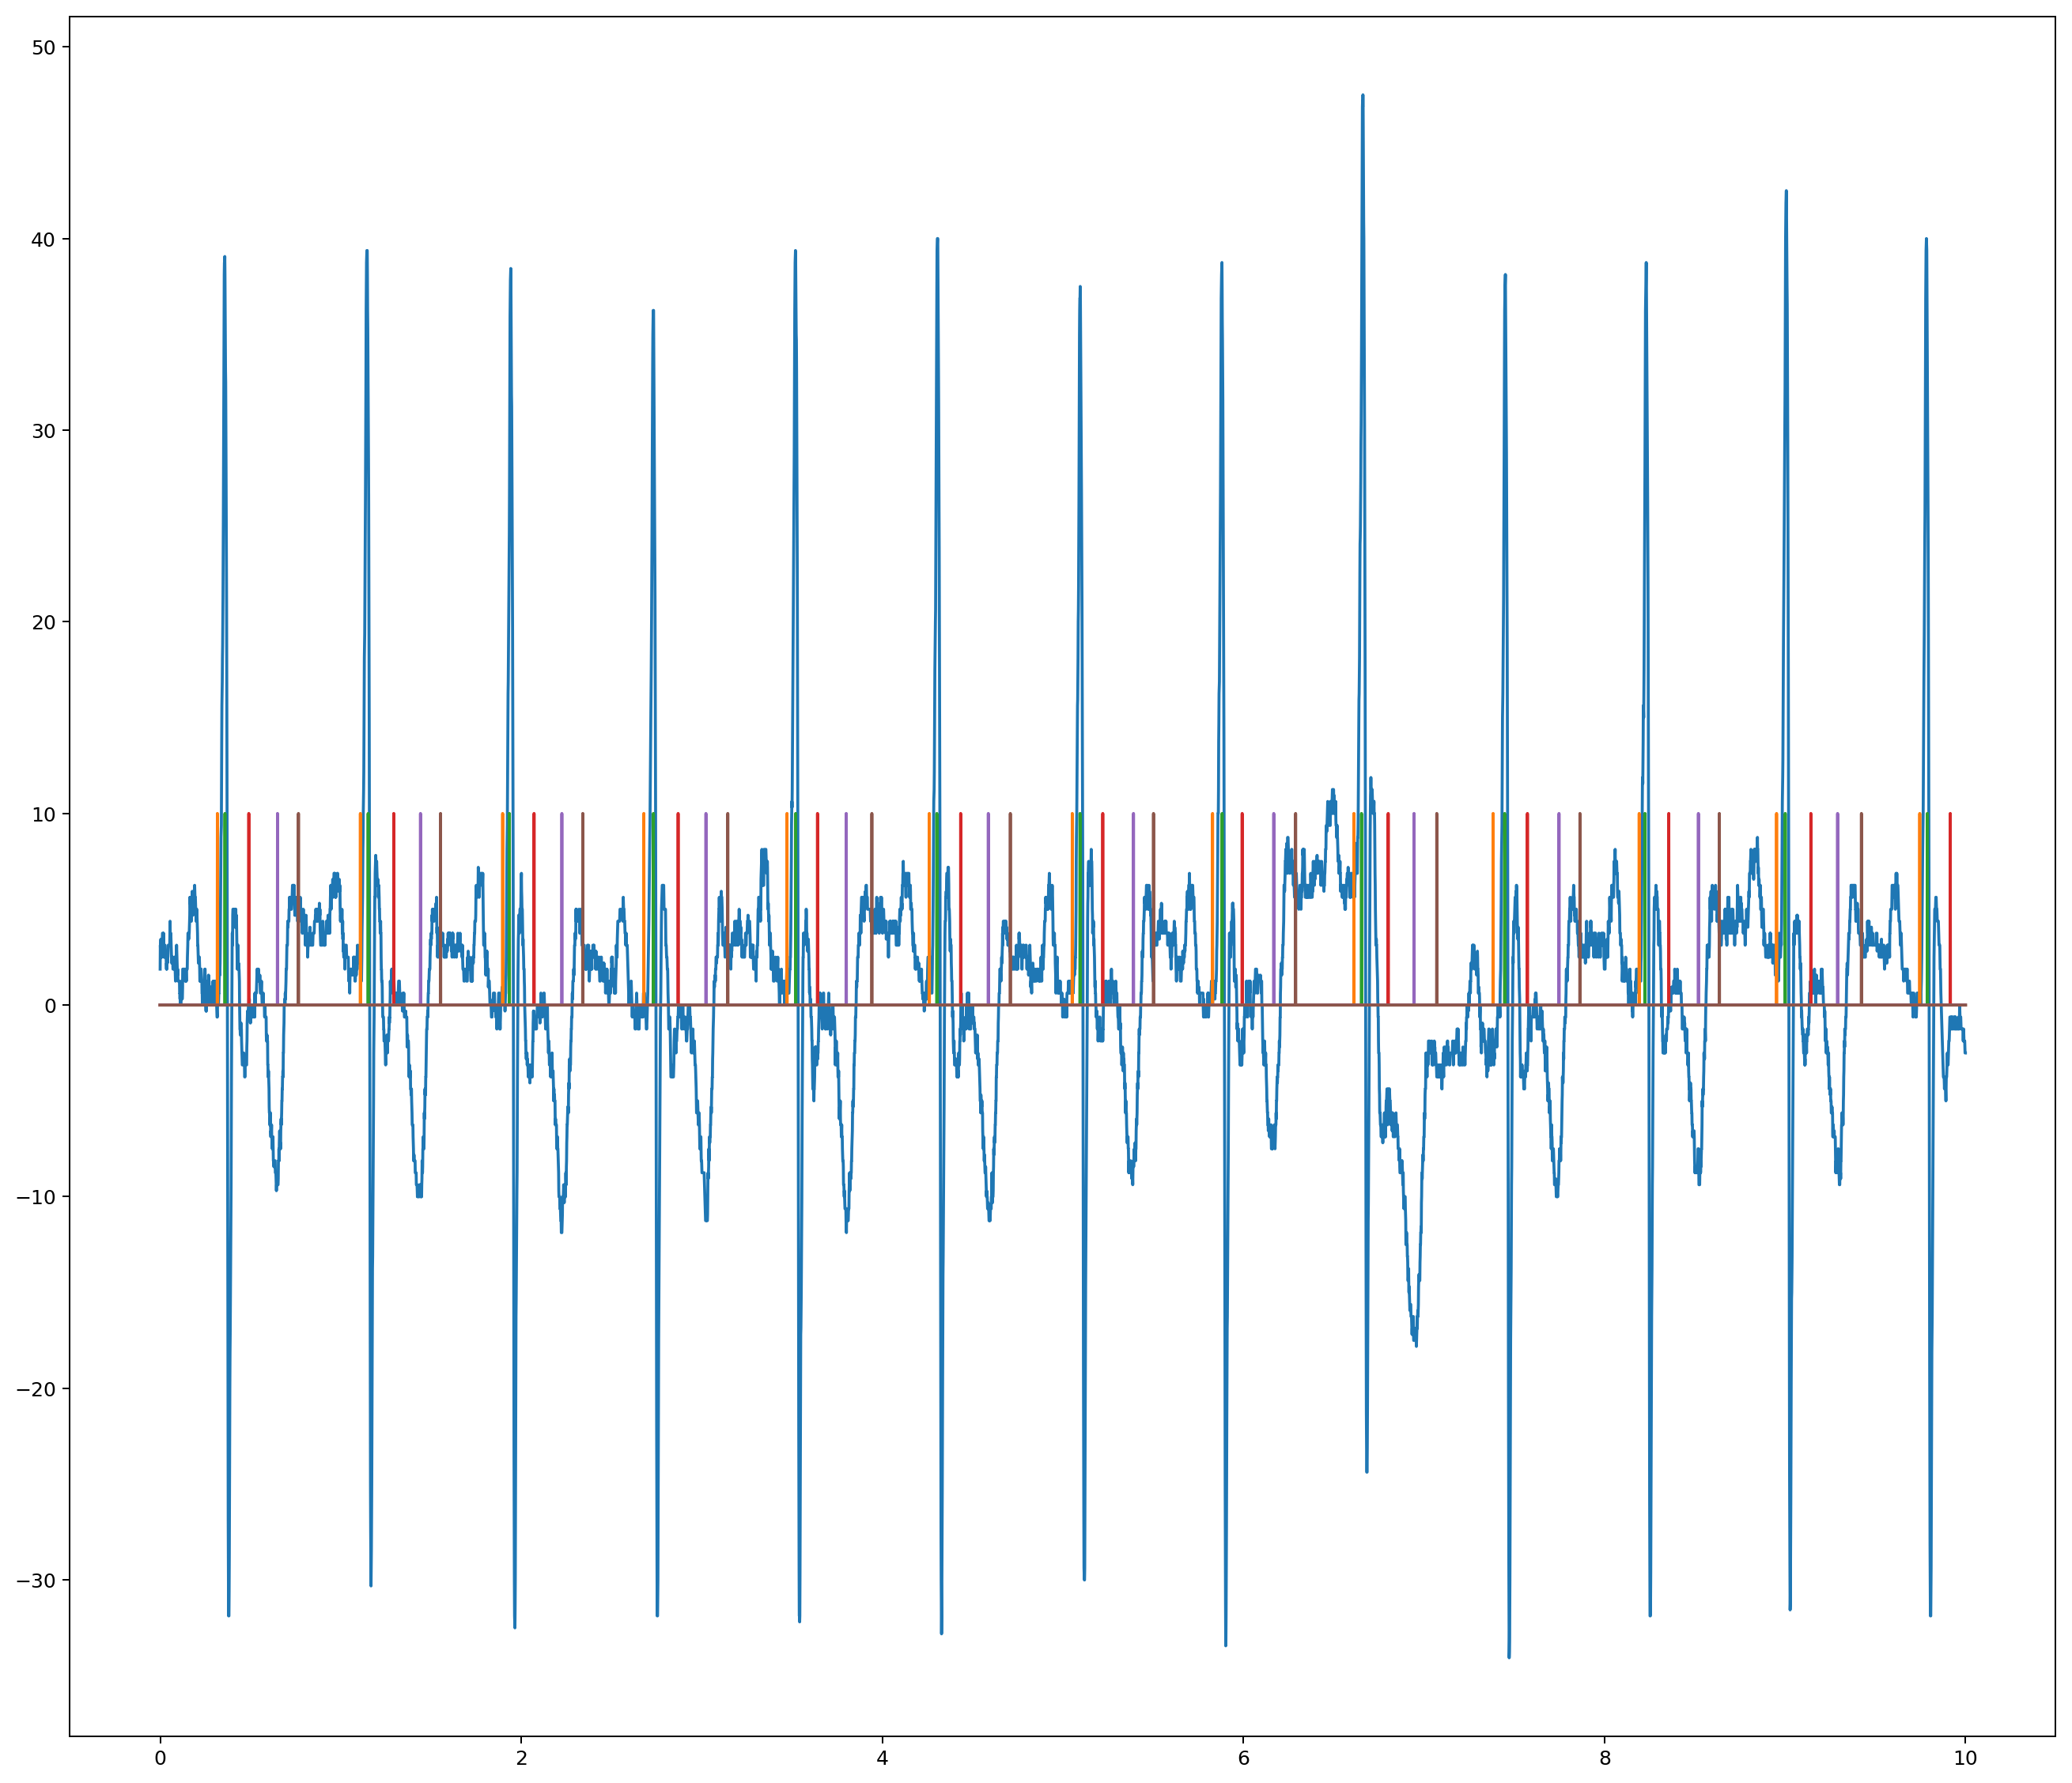

In [58]:
from os import listdir
from matplotlib import pyplot as plt

data_path = 'ecg_data'
filelist = listdir(data_path)

file_example = filelist[0]
print(file_example)
data_example = np.loadtxt(open(data_path + '/' + file_example, 'rb'), delimiter=',', skiprows=0)

fig=plt.figure(figsize=(18, 16), dpi= 180, facecolor='w', edgecolor='k')
Y_data = np.zeros((data_example[:, 2].shape))
qt_interval = False
q_on = 0
t_off = -1
q_on_index = np.where(data_example[:, 2])[0]
t_off_index = np.where(data_example[:, 6])[0]
print(q_on_index)
print(t_off_index)
j = 0
for i in range(len(q_on_index)):
    if q_on_index[i] < t_off_index[j]:
        Y_data[q_on_index[i] : t_off_index[j]+1] = 1

plt.plot(data_example[:, 0], np.concatenate((data_example[:, 1:2], data_example[:, 2:]*10), axis=1))
data_example.shape
a = np.array([0, 0, 0, 0, 0])
print(type(a))
a[1:3+1]= 1
a

## Load ECG data

### Create template dataset

In [ ]:
def generate_all_data(data, window_size, jump_size, combinations, give_files=False, 
                      unlabelled=False):
    """"""
    if give_files:
        X_data = []
        Y_data = []
        # Prepare data
        epoch_data = [(patient[0], file) for patient in list(data.items()) for 
                      file in patient[1]]
        n_files = len(epoch_data)

        # Fill the data structures
        for combination_it in range(combinations):
            for file_it in range(n_files):
                file_name = epoch_data[file_it][0]
                file_size = len(epoch_data[file_it][1])
                data_size = int((file_size-window_size-jump_size)/jump_size)+1
                if data_size < 1:
                    print('OH SHIT')
                    continue
                X_data.append((file_name, np.zeros((data_size, window_size + jump_size, 2))))
                Y_r=np.zeros((data_size, window_size + jump_size))
                for window_it in range(0, file_size - window_size - jump_size, jump_size):
                    X_raw = epoch_data[file_it][1][window_it:window_it + window_size + 
                                                   jump_size, :]
                    X_1 = np.asarray(X_raw[:, 0])
                    X_2 = np.asarray(X_raw[:, 1])
                    Y_r[int(window_it/jump_size), :] = np.asarray(X_raw[:, 2])

                    # Center to zero and reshape
                    mean_X1 = X_1.mean()
                    std_X1 = X_1.std()
                    X_1 = X_1 - mean_X1
                    X_1 = X_1 / std_X1

                    mean_X2 = X_2.mean()
                    std_X2 = X_2.std()
                    X_2 = X_2 - mean_X2
                    X_2 = X_2 / std_X2

                    # Combinations to become independent of the lead
                    if combination_it == 0:
                        X_data[-1][1][int(window_it/jump_size), :, 0] = X_1
                        X_data[-1][1][int(window_it/jump_size), :, 1] = X_2
                    elif combination_it == 1:
                        X_data[-1][1][int(window_it / jump_size), :, 0] = X_2
                        X_data[-1][1][int(window_it / jump_size), :, 1] = X_1

                # Organise the results
                Y_data.append(Y_r)

    else:
        # Prepare data
        epoch_data = [(patient[0], file) for patient in list(data.items()) for 
                      file in patient[1]]
        n_files = len(epoch_data)

        # Count samples in the data
        n_samples = 0
        for combination_it in range(combinations):
            for file_it in range(n_files):
                file_size = len(epoch_data[file_it][1])
                for window_it in range(0, file_size - window_size - jump_size, jump_size):
                    n_samples += 1

        # Create data structures
        X_data = np.zeros((n_samples, window_size + jump_size, 2))
        if unlabelled:
            Y_data = np.zeros((n_samples, window_size + jump_size, 2))
        else:
            Y_data = np.zeros((n_samples, window_size + jump_size, 3))

        # Fill the data structures
        data_it = 0
        for combination_it in range(combinations):
            for file_it in range(n_files):
                # file_name = epoch_data[file_it][0]
                file_size = len(epoch_data[file_it][1])
                for window_it in range(0, file_size - window_size - jump_size, jump_size):
                    X_raw = epoch_data[file_it][1][window_it:window_it + 
                                                   window_size + jump_size, :]
                    X_1 = np.asarray(X_raw[:, 0])
                    X_2 = np.asarray(X_raw[:, 1])

                    # Center to zero and reshape
                    mean_X1 = X_1.mean()
                    std_X1 = X_1.std()
                    X_1 = X_1 - mean_X1
                    X_1 = X_1 / std_X1

                    mean_X2 = X_2.mean()
                    std_X2 = X_2.std()
                    X_2 = X_2 - mean_X2
                    X_2 = X_2 / std_X2

                    # Combinations to become independent of the lead
                    if combination_it == 0:
                        X_data[data_it, :, 0] = X_1
                        X_data[data_it, :, 1] = X_2
                    elif combination_it == 1:
                        X_data[data_it, :, 0] = X_2
                        X_data[data_it, :, 1] = X_1
                    # elif combination_it == 2:
                    #     X_data[data_it, :, 0] = X_1
                    #     X_data[data_it, :, 1] = X_1
                    # elif combination_it == 3:
                    #     X_data[data_it, :, 0] = X_2
                    #     X_data[data_it, :, 1] = X_2

                    if unlabelled:
                        Y_data[data_it, :, :] = X_data[data_it, :, :]
                    else:
                        Y_data[data_it, :, :] = np.asarray(X_raw[:, 2:5])

                    data_it += 1
    return X_data, Y_data

### Generator - augments the template dataset

In [ ]:
def augmentator(X, Y, window_size, batch_size, is_RNN, is_special):
    """"""

    # Prepare augmentation parameters
    n_samples = X.shape[0]
    if n_samples < batch_size*4:
        duplication_factor = math.ceil(batch_size*2/n_samples)
        X = np.tile(X, (duplication_factor, 1, 1))
        Y = np.tile(Y, (duplication_factor, 1, 1))
        n_samples = X.shape[0]

    # Deformation parameters
    deform_clip_a = 0.75
    deform_clip_b = 1.25
    deform_mean = 1.
    deform_std = 0.5
    deform_a, deform_b = (deform_clip_a - deform_mean) / deform_std, (deform_clip_b - deform_mean) / deform_std
    # Shifting base parameters
    base_clip_a = -1.
    base_clip_b = 1.
    base_mean = 0.
    base_std = 0.5
    base_a, base_b = (base_clip_a - base_mean) / base_std, (base_clip_b - base_mean) / base_std

    # Infinite loop
    while True:
        # Shuffle data
        if not is_RNN:
            s = np.arange(n_samples)
            np.random.shuffle(s)
            X = X[s, :, :]
            Y = Y[s, :, :]
        # Loop over samples
        for it_sample in range(0, n_samples-batch_size, batch_size):
            bases = np.zeros((batch_size, 2))
            deforms = np.zeros((batch_size, 2))
            bases[np.random.randint(0, batch_size, int(batch_size/2), dtype='int'), :] = np.reshape(truncnorm(a=base_a, b=base_b, scale=base_std).rvs(size=int(batch_size)), (int(batch_size/2), 2))
            deforms[np.random.randint(0, batch_size, int(batch_size/2), dtype='int'), :] = np.reshape(truncnorm(a=deform_a, b=deform_b, scale=deform_std).rvs(size=int(batch_size)), (int(batch_size/2), 2))
            deforms += deform_mean
            shift = rd.randint(0, X.shape[1]-window_size)
            batch_X = np.transpose(np.multiply(np.add(np.transpose(X[it_sample:it_sample+batch_size, shift:window_size+shift, :], (1, 0, 2)), bases), deforms), (1, 0, 2))
            # batch_X = X[it_sample:it_sample+batch_size, shift:window_size+shift, :]
            if is_RNN or is_special:
                batch_Y_p = Y[it_sample:it_sample+batch_size, shift:window_size+shift, 0:1]
                batch_Y_r = Y[it_sample:it_sample+batch_size, shift:window_size+shift, 1:2]
                batch_Y_t = Y[it_sample:it_sample+batch_size, shift:window_size+shift, 2:]
            else:
                batch_Y_p = Y[it_sample:it_sample+batch_size, shift:window_size+shift, 0]
                batch_Y_r = Y[it_sample:it_sample+batch_size, shift:window_size+shift, 1]
                batch_Y_t = Y[it_sample:it_sample+batch_size, shift:window_size+shift, 2]

            yield (batch_X, {'p_output': batch_Y_p, 'r_output': batch_Y_r, 't_output': batch_Y_t})

### Main generator - Runs the codes and creates the train and validation generators

In [26]:
import random as rd
import numpy as np

data_path = 'ecg_data'
filelist = [ecg_file for ecg_file in listdir(data_path) if ecg_file.startswith('ecg_')]

data = {}

for file_name in filelist:
    file_name_split = file_name.split('_')
    patient = file_name_split[1]
    if patient not in data:
        data[patient] = [np.loadtxt(open(data_path + '/' + file_example, 'rb'), delimiter=',', 
                          skiprows=0, usecols=(1,2,3,4,5,6))]
    else:
        data[patient] += [np.loadtxt(open(data_path + '/' + file_example, 'rb'), delimiter=',', 
                          skiprows=0, usecols=(1,2,3,4,5,6))]

window_size = _WINDOW_SIZE
jump_size = _JUMP_SIZE
combinations = 2

# Prepare data
epoch_data = [(patient[0], file) for patient in list(data.items()) for 
              file in patient[1]]
n_files = len(epoch_data)

# Count samples in the data
n_samples = 0
for combination_it in range(combinations):
    for file_it in range(n_files):
        file_size = len(epoch_data[file_it][1])
        for window_it in range(0, file_size - window_size - jump_size, jump_size):
            n_samples += 1

# Create data structures
X_data = np.zeros((n_samples, window_size + jump_size, 1))
Y_data = np.zeros((n_samples, window_size + jump_size, 5))

In [35]:
# Fill the data structures
data_it = 0
for file_it in range(n_files):
    # file_name = epoch_data[file_it][0]
    file_size = len(epoch_data[file_it][1])
    for window_it in range(0, file_size - window_size - jump_size, jump_size):
        X_raw = epoch_data[file_it][1][window_it:window_it + 
                                       window_size + jump_size, :]
        X_1 = np.asarray(X_raw[:, 0])

        # Center to zero and reshape
        mean_X1 = X_1.mean()
        std_X1 = X_1.std()
        X_1 = X_1 - mean_X1
        X_1 = X_1 / std_X1

        X_data[data_it, :, 0] = X_1
        Y_data[data_it, :, :] = np.asarray(X_raw[:, 1:6])
        #Y_data[data_it, :, :] = np.asarray(X_raw[:, 1:6])
        
        data_it += 1


array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0.,

In [5]:



qrs_X_train = X_data
qrs_Y_train = Y_data



train_generator = augmentator(qrs_X_train, qrs_Y_train, input_size, batch_size, is_RNN, 
                              special_model)






ecg_1_20180201075412_20180328084533_4_aVR.csv


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Test generator - counts data and in the generator (requieres changes in the code)

In [ ]:
from definitions import get_patient_partition

data_freq = 250
database = 'qtdb'
configurations = [
    {
        'window_time': 4.096,
        'batch_size': 512,
        # 'window_time': 0.204,
        # 'batch_size': 1024
    }
]
train_deep_model = True
# train_deep_model = False
[train, validation, test] = get_patient_partition()
[train_patient, val_patient,
 test_patient] = get_patient_split(data_freq, database, train, validation, test)
train_data = get_dataset(train_patient)
validation_data = get_dataset(val_patient)
test_data = get_dataset(test_patient)
for conf in configurations:
    window_time = conf['window_time']
    batch_size = conf['batch_size']
    window_size = int(window_time * data_freq)

    print('('+"'"+'f'+str(data_freq)+'_w'+(str(
        window_time).replace('.','_'))+'_b'+str(
        batch_size)+"'" + ', {\n    '+"'"+'data_freq'+"'"+': '
          + str(data_freq)+',\n    '+"'"+'window_time'+"'"+': '
          + str(window_time)+',\n    '+"'"+'batch_size'+"'"+': '
          + str(batch_size)+',')
    get_generator(train_data, window_size, batch_size, augmentation=4, predict=False, 
                  train_deep_model=train_deep_model)
    get_generator(validation_data, window_size, batch_size, augmentation=1, predict=True, 
                  train_deep_model=train_deep_model)
    print('    ' + "'" + 'n_test' + "'" + ': ' + str(0) + ',\n    ' + "'" + '\n}),')
    get_generator(test_data, window_size, batch_size, augmentation=1, predict=True, 
                  train_deep_model=train_deep_model)

print('END')

## Model

In [5]:
def compile_model(model, learning_rate, loss, loss_weights):
        """"""
        optimizer = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08,
                                          decay=0.0, clipvalue=1.)
        model.compile(optimizer=optimizer, loss=loss, loss_weights=loss_weights, metrics=None)
        return model
    
    
def build_model_waves(input_shape, kernel_size, n_conv_layers, n_dense_layers, n_conv_kernels, n_dense_neurons,
                      learning_rate, dropout, initialiser, loss, loss_weight,
                      regularisation_type=None, regularisation_value=0., model_autoencoder=None):
    """Build the model"""
    with tf.device('/cpu:0'):
        main_input = keras.layers.Input(shape=input_shape, name='main_input')
        if regularisation_type is not None:
            if regularisation_type == 'l1':
                regularisation = keras.regularizers.l1(regularisation_value)
            elif regularisation_type == 'l2':
                regularisation = keras.regularizers.l2(regularisation_value)
            elif regularisation_type == 'l1_l2':
                regularisation = keras.regularizers.l1_l2(regularisation_value)
            elif regularisation_type == 'None':
                regularisation = None
            else:
                regularisation = None
        else:
            regularisation = None

        first_was_dense = False

        if n_conv_layers > 0:
            conved = keras.layers.Conv1D(filters=n_conv_kernels, kernel_size=kernel_size, strides=1, padding='valid',
                                         dilation_rate=1, use_bias=True, kernel_initializer=initialiser,
                                         bias_initializer='zeros',
                                         kernel_regularizer=regularisation, bias_regularizer=None,
                                         activity_regularizer=None,
                                         kernel_constraint=None, bias_constraint=None, name='conv_0')(main_input)
            conved = keras.layers.BatchNormalization()(conved)
            conved = keras.layers.Activation(activation='relu')(conved)
        elif n_dense_layers > 0:
            dense_out = keras.layers.Dense(units=n_dense_neurons, use_bias=True,
                                           kernel_initializer=initialiser, bias_initializer='zeros',
                                           kernel_regularizer=regularisation, bias_regularizer=None,
                                           activity_regularizer=None,
                                           kernel_constraint=None, bias_constraint=None, name='dense_0')(main_input)
            dense_out = keras.layers.BatchNormalization()(dense_out)
            dense_out = keras.layers.Activation(activation='relu')(dense_out)
            if dropout > 0.:
                dense_out = keras.layers.Dropout(dropout)(dense_out)
            first_was_dense = True

        if n_conv_layers > 0:
            n_conv_layers -= 1
            for i in range(n_conv_layers):
                conved = keras.layers.Conv1D(filters=n_conv_kernels, kernel_size=kernel_size, strides=1, padding='valid',
                                             dilation_rate=1, use_bias=True,
                                             kernel_initializer=initialiser,
                                             bias_initializer='zeros', kernel_regularizer=regularisation,
                                             bias_regularizer=None,
                                             activity_regularizer=None, kernel_constraint=None, bias_constraint=None,
                                             name='conv_' + str(i+1))(conved)
                conved = keras.layers.BatchNormalization()(conved)
                conved = keras.layers.Activation(activation='relu')(conved)
            dense_out = keras.layers.Flatten()(conved)

        if n_dense_layers > 0:
            if first_was_dense:
                n_dense_layers -= 1
                n_dense_neurons *= 2
            for i in range(n_dense_layers):
                dense_out = keras.layers.Dense(units=n_dense_neurons, use_bias=True, kernel_initializer=initialiser,
                                               bias_initializer='zeros',
                                               kernel_regularizer=regularisation, bias_regularizer=None,
                                               activity_regularizer=None, kernel_constraint=None,
                                               bias_constraint=None, name='dense_' + str(i+1))(dense_out)
                dense_out = keras.layers.BatchNormalization()(dense_out)
                dense_out = keras.layers.Activation(activation='relu')(dense_out)
                if dropout > 0.:
                    dense_out = keras.layers.Dropout(dropout)(dense_out)
                n_dense_neurons *= 2

        # Connect the new output layers
        r_out = keras.layers.Dense(units=input_shape[0], activation='sigmoid', use_bias=True,
                                   kernel_initializer=initialiser, bias_initializer='zeros',
                                   kernel_regularizer=regularisation, bias_regularizer=None, activity_regularizer=None,
                                   kernel_constraint=None,
                                   bias_constraint=None, name='r_output')(dense_out)
        t_out = keras.layers.Dense(units=input_shape[0], activation='sigmoid', use_bias=True,
                                   kernel_initializer=initialiser, bias_initializer='zeros',
                                   kernel_regularizer=regularisation, bias_regularizer=None, activity_regularizer=None,
                                   kernel_constraint=None,
                                   bias_constraint=None, name='t_output')(dense_out)

        # Instantiate the base model (or "template" model).
        # We recommend doing this with under a CPU device scope,
        # so that the model's weights are hosted on CPU memory.
        # Otherwise they may end up hosted on a GPU, which would
        # complicate weight sharing.
        model = keras.models.Model(inputs=main_input, outputs=[r_out, t_out])

        

        # print(model.summary())

    # Replicates the model on 8 GPUs
    # This assumes that your machine has 8 available GPUs.
    parallel_model = multi_gpu_model(model, gpus=8)
    parallel_model = compile_model(parallel_model, learning_rate, loss, [loss_weight[0], loss_weight[1]])
    
    # Generate dummy data.
    num_samples = 1000
#     height = 224
    width = 256
    num_classes = 1
    x = np.random.random((num_samples, width, 1))
    y = np.random.random((num_samples, width))
    
    # This `fit` call will be distributed on 8 GPUs.
    # Since the batch size is 256, each GPU will process 32 samples.
    parallel_model.fit(x, [y, y], epochs=10, batch_size=512)
    
    # Save model via the template model (which shares the same weights):
    model.save('my_model.h5')
    
    return model, parallel_model

## Load Model

In [7]:
model = build_model_waves((256, 1), (3), 3, 2, 16, 124, 5e-04, 0.5, 'glorot_normal', 
                          'binary_crossentropy', [1., .9], None, 0., None)

Epoch 1/10
1000/1000 [==============================] - 10s 10ms/step - loss: 1.5234 - r_output_loss: 0.8012 - t_output_loss: 0.8025
Epoch 2/10
1000/1000 [==============================] - 0s 85us/step - loss: 1.5104 - r_output_loss: 0.7937 - t_output_loss: 0.7964
Epoch 3/10
1000/1000 [==============================] - 0s 89us/step - loss: 1.4997 - r_output_loss: 0.7879 - t_output_loss: 0.7909
Epoch 4/10
1000/1000 [==============================] - 0s 95us/step - loss: 1.4914 - r_output_loss: 0.7850 - t_output_loss: 0.7848
Epoch 5/10
1000/1000 [==============================] - 0s 91us/step - loss: 1.4861 - r_output_loss: 0.7820 - t_output_loss: 0.7824
Epoch 6/10
1000/1000 [==============================] - 0s 89us/step - loss: 1.4772 - r_output_loss: 0.7767 - t_output_loss: 0.7784
Epoch 7/10
1000/1000 [==============================] - 0s 94us/step - loss: 1.4717 - r_output_loss: 0.7746 - t_output_loss: 0.7745
Epoch 8/10
1000/1000 [==============================] - 0s 90us/step - loss

## Train Model

In [ ]:
def hyperparameters_search(qrs_train_data, qrs_validation_data, #qrsT_train_data, qrsT_validation_data,
                           all_train_data, all_validation_data, un_train_data, input_size, batch_size, jump_size, domain,
                           experiment_id, initialisation, class_weight, learning_rate, loss_function, loss_weight,
                           nb_epochs, max_wave_size, max_iterations, initial_design_numdata, is_RNN, semisupervised,
                           special_model, train_deep_model, only_qrs):
    """"""
    waves_batch_size = 1024
    waves_window_size = 64
    fusion_window_size = 9
    fusion_batch_size = 512
    fusion_nb_epochs_waves = 8
    delineation_nb_epochs = 15 # 15

    fusion_class_weight_waves = {'fusion_output_1': {1: 1., 0: 0.22}, 'fusion_output_2': {1: 1., 0: 0.18},
                                     'fusion_output_3': {1: 1., 0: 0.22}}

    fusion_nb_epochs_delineate = 4
    fusion_class_weight_delineate = {'fusion_output_1': {1: 1., 0: 0.32}, 'fusion_output_2': {1: 1., 0: 0.32},
                                     'fusion_output_3': {1: 1., 0: 0.32}}

    # GENERATE TRAINING DATA
    X_train, Y_train = generate_all_data(train_data, input_size, jump_size=jump_size, combinations=2)
    X_val, Y_val = generate_all_data(validation_data, input_size, jump_size=jump_size, combinations=2)
    n_train = max(2, int(X_train.shape[0]/batch_size))

    X_train_plain, Y_train_plain, ref_train_file_names = generate_plain_data(train_data)
    X_val_plain, Y_val_plain, ref_val_file_names = generate_plain_data(validation_data)

    def cost_function_deep(x):
        """"""
        args = x[0]
        n_conv_layers=int(args[0])
        n_dense_layers=int(args[1])
        n_conv_kernels=int(args[2])
        n_dense_neurons=int(args[3])

        # Fusion models
        fusion_model_waves, parallel_fusion_model_waves = build_model_fusion((fusion_window_size, 2, 3), 5e-04)

        # ConvNet models        
        model_waves, parallel_model_waves = build_model_waves(input_shape=(input_size, 2), kernel_size=(3), n_conv_layers=16,
                                                          n_dense_layers=2, n_conv_kernels=16, n_dense_neurons=128,
                                                          dropout=0.5, learning_rate=learning_rate,
                                                          initialiser=initialisation, loss=loss_function,
                                                          loss_weight=loss_weight, regularisation_type=None,
                                                          regularisation_value=0., model_autoencoder=model_waves_autoencoder)
        # R delineation model
        r_model_delineate, r_parallel_model_delineate = build_model_delineate(
            input_shape=(waves_window_size, 2), kernel_size=(5), n_conv_layers=8, n_dense_layers=2,
            n_conv_kernels=16, n_dense_neurons=128, dropout=0.5,
            learning_rate=learning_rate, loss=loss_function, loss_weight=[1., 1.], initialiser=initialisation,
            # regularisation_type='l2', regularisation_value=0.01,
            model_autoencoder=model_delineate_autoencoder)

        # Start with data from qrs
        print('\nQRS\n')
        train_file_names = ref_train_file_names
        val_file_names = ref_val_file_names
        
        # Train the model
        train_generator = augmentator(X_train, Y_train, input_size, batch_size, is_RNN, special_model)
        parallel_model_waves.fit_generator(train_generator, steps_per_epoch=qrs_n_train*jump_size/4, epochs=20,
                                           verbose=1, callbacks=None, class_weight=class_weight, max_queue_size=64)

        # Generate predictions
        [(p_train_precision, p_train_recall), (r_train_precision, r_train_recall), (t_train_precision, t_train_recall)] = 
        evaluate_model_old(parallel_model_waves, qrs_X_train, qrs_Y_train, input_size, batch_size, is_RNN, special_model)
        [(p_val_precision, p_val_recall), (r_val_precision, r_val_recall), (t_val_precision, t_val_recall)] = 
        evaluate_model_old(parallel_model_waves, qrs_X_val, qrs_Y_val, input_size, batch_size, is_RNN, special_model)
        print('\nTRAIN METRICS - P - precision: ' + str(p_train_precision) + ' recall: ' + str(p_train_recall) +
              '\nVAL METRICS - P - precision: ' + str(p_val_precision) + ' recall: ' + str(p_val_recall))
        print('\nTRAIN METRICS - R - precision: ' + str(r_train_precision) + ' recall: ' + str(r_train_recall) +
              '\nVAL METRICS - R - precision: ' + str(r_val_precision) + ' recall: ' + str(r_val_recall))
        print('\nTRAIN METRICS - T - precision: ' + str(t_train_precision) + ' recall: ' + str(t_train_recall) +
              '\nVAL METRICS - T - precision: ' + str(t_val_precision) + ' recall: ' + str(t_val_recall))

        exit(0)
        
        
        
        
        
        
        train_predictions, val_predictions, parallel_fusion_model_waves, qrs_train_file_names, qrs_val_file_names = predict_model(
            parallel_model_waves, parallel_fusion_model_waves, fusion_nb_epochs_waves, fusion_class_weight_waves,
            qrs_X_train_plain, qrs_Y_train_plain, qrs_train_file_names, qrs_X_val_plain, qrs_Y_val_plain, qrs_val_file_names, input_size, batch_size,
            fusion_window_size, fusion_batch_size, is_RNN, special_model)
        train_conf_mat_p, train_conf_mat_r, train_conf_mat_t = calc_conf_mat_from_prediction(train_predictions)
        val_conf_mat_p, val_conf_mat_r, val_conf_mat_t = calc_conf_mat_from_prediction(val_predictions)

        # Metrics for p wave
        train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_p)
        val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_p)
        print('\nTRAIN METRICS - P - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
              '\nVAL METRICS - P - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))
        # Metrics for r wave
        train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_r)
        val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_r)
        print('\nTRAIN METRICS - R - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
              '\nVAL METRICS - R - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))
        # Metrics for t wave
        train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_t)
        val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_t)
        print('\nTRAIN METRICS - T - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
              '\nVAL METRICS - T - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))

        # Finding waves part
        qrs_train_p_delineate_data, qrs_train_p_count, qrs_train_found_p_count, qrs_train_correct_found_p_count, qrs_train_r_delineate_data, \
        qrs_train_r_count, qrs_train_found_r_count, qrs_train_correct_found_r_count, qrs_train_t_delineate_data, qrs_train_t_count, \
        qrs_train_found_t_count, qrs_train_correct_found_t_count, qrs_train_p_file_names, qrs_train_r_file_names, \
            qrs_train_t_file_names = find_all_waves_from_predictions(train_predictions, qrs_train_file_names, max_wave_size)

        qrs_val_p_delineate_data, qrs_val_p_count, qrs_val_found_p_count, qrs_val_correct_found_p_count, qrs_val_r_delineate_data, \
        qrs_val_r_count, qrs_val_found_r_count, qrs_val_correct_found_r_count, qrs_val_t_delineate_data, qrs_val_t_count, \
        qrs_val_found_t_count, qrs_val_correct_found_t_count, qrs_val_p_file_names, qrs_val_r_file_names, \
            qrs_val_t_file_names = find_all_waves_from_predictions(val_predictions, qrs_val_file_names, max_wave_size, is_val=True)

        print('\nTRAIN - P waves: ' + str(qrs_train_p_count) + ', ' + str(qrs_train_found_p_count) + ', ' + str(qrs_train_correct_found_p_count)
              + '\nVAL - P waves: ' + str(qrs_val_p_count) + ', ' + str(qrs_val_found_p_count) + ', ' + str(qrs_val_correct_found_p_count))
        print('\nTRAIN - R waves: ' + str(qrs_train_r_count) + ', ' + str(qrs_train_found_r_count) + ', ' + str(qrs_train_correct_found_r_count)
              + '\nVAL - R waves: ' + str(qrs_val_r_count) + ', ' + str(qrs_val_found_r_count) + ', ' + str(qrs_val_correct_found_r_count))
        print('\nTRAIN - T waves: ' + str(qrs_train_t_count) + ', ' + str(qrs_train_found_t_count) + ', ' + str(qrs_train_correct_found_t_count)
              + '\nVAL - T waves: ' + str(qrs_val_t_count) + ', ' + str(qrs_val_found_t_count) + ', ' + str(qrs_val_correct_found_t_count))
        # exit(0)
        # for X, y_true, y_pred in val_predictions:
        #     # y_pred = np.where(np.asarray(y_pred) >= 0.5, 2, 0)
        #     with open('aux_qrs_pred.csv', 'a') as log_file:
        #         log_file.write('\n\n')
        #         for it_x in range(X.shape[0]):
        #             log_file.write(str(X[it_x, 0]) + ' ' + str(X[it_x, 1]) + ' ' + str(y_true[it_x, 0]) + ' '
        #                            + str(y_true[it_x, 1]) + ' ' + str(y_true[it_x, 2]) + ' ' + str(y_pred[it_x, 0])
        #                            + ' ' + str(y_pred[it_x, 1]) + ' ' + str(y_pred[it_x, 2]) + '\n')
        if not only_qrs:
            # # Repeat but for only files with qrsT waves
            # print('\nQRST\n')
            # qrsT_val_file_names = ref_qrsT_val_file_names
            # qrsT_train_file_names = ref_qrsT_train_file_names
            # # Train the model for a few epochs
            # train_generator = augmentator(qrsT_X_train, qrsT_Y_train, input_size, batch_size, is_RNN, special_model)
            # parallel_model_waves.fit_generator(train_generator, steps_per_epoch=qrsT_n_train * jump_size, epochs=1,
            #                                    verbose=1, callbacks=None, class_weight=class_weight, max_queue_size=64)
            #
            # # Generate predictions
            # train_predictions, val_predictions, parallel_fusion_model_waves, qrsT_train_file_names, qrsT_val_file_names = predict_model(
            #     parallel_model_waves, parallel_fusion_model_waves, fusion_nb_epochs_waves, fusion_class_weight_waves,
            #     qrsT_X_train_plain, qrsT_Y_train_plain, qrsT_train_file_names, qrsT_X_val_plain, qrsT_Y_val_plain, qrsT_val_file_names, input_size, batch_size,
            #     fusion_window_size, fusion_batch_size, is_RNN, special_model)
            # train_conf_mat_p, train_conf_mat_r, train_conf_mat_t = calc_conf_mat_from_prediction(train_predictions)
            # val_conf_mat_p, val_conf_mat_r, val_conf_mat_t = calc_conf_mat_from_prediction(val_predictions)
            # # Metrics for p wave
            # train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_p)
            # val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_p)
            # print('\nTRAIN METRICS - P - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
            #       '\nVAL METRICS - P - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))
            # # Metrics for r wave
            # train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_r)
            # val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_r)
            # print('\nTRAIN METRICS - R - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
            #       '\nVAL METRICS - R - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))
            # # Metrics for t wave
            # train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_t)
            # val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_t)
            # print('\nTRAIN METRICS - T - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
            #       '\nVAL METRICS - T - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))
            #
            # # Finding waves part
            # qrsT_train_p_delineate_data, qrsT_train_p_count, qrsT_train_found_p_count, qrsT_train_correct_found_p_count, qrsT_train_r_delineate_data, \
            # qrsT_train_r_count, qrsT_train_found_r_count, qrsT_train_correct_found_r_count, qrsT_train_t_delineate_data, qrsT_train_t_count, \
            # qrsT_train_found_t_count, qrsT_train_correct_found_t_count, qrsT_train_p_file_names, qrsT_train_r_file_names, \
            # qrsT_train_t_file_names = find_all_waves_from_predictions(train_predictions, qrsT_train_file_names, max_wave_size)
            #
            # qrsT_val_p_delineate_data, qrsT_val_p_count, qrsT_val_found_p_count, qrsT_val_correct_found_p_count, qrsT_val_r_delineate_data, \
            # qrsT_val_r_count, qrsT_val_found_r_count, qrsT_val_correct_found_r_count, qrsT_val_t_delineate_data, qrsT_val_t_count, \
            # qrsT_val_found_t_count, qrsT_val_correct_found_t_count, qrsT_val_p_file_names, qrsT_val_r_file_names, \
            # qrsT_val_t_file_names = find_all_waves_from_predictions(val_predictions, qrsT_val_file_names, max_wave_size, is_val=True)
            #
            # print('\nTRAIN - P waves: ' + str(qrsT_train_p_count) + ', ' + str(qrsT_train_found_p_count) + ', ' + str(qrsT_train_correct_found_p_count)
            #       + '\nVAL - P waves: ' + str(qrsT_val_p_count) + ', ' + str(qrsT_val_found_p_count) + ', ' + str(qrsT_val_correct_found_p_count))
            # print('\nTRAIN - R waves: ' + str(qrsT_train_r_count) + ', ' + str(qrsT_train_found_r_count) + ', ' + str(qrsT_train_correct_found_r_count)
            #       + '\nVAL - R waves: ' + str(qrsT_val_r_count) + ', ' + str(qrsT_val_found_r_count) + ', ' + str(qrsT_val_correct_found_r_count))
            # print('\nTRAIN - T waves: ' + str(qrsT_train_t_count) + ', ' + str(qrsT_train_found_t_count) + ', ' + str(qrsT_train_correct_found_t_count)
            #       + '\nVAL - T waves: ' + str(qrsT_val_t_count) + ', ' + str(qrsT_val_found_t_count) + ', ' + str(qrsT_val_correct_found_t_count))

            # Repeat but for only files with all waves
            print('\nALL\n')
            all_train_file_names = ref_all_train_file_names
            all_val_file_names = ref_all_val_file_names
            # Train the model for a few epochs
            train_generator = augmentator(all_X_train, all_Y_train, input_size, batch_size, is_RNN, special_model)
            parallel_model_waves.fit_generator(train_generator, steps_per_epoch=all_n_train * jump_size, epochs=1,
                                               verbose=1, callbacks=None, class_weight=class_weight, max_queue_size=64)

            # Generate predictions
            train_predictions, val_predictions, parallel_fusion_model_waves, all_train_file_names, all_val_file_names = predict_model(
                parallel_model_waves, parallel_fusion_model_waves, fusion_nb_epochs_waves, fusion_class_weight_waves,
                all_X_train_plain, all_Y_train_plain, all_train_file_names, all_X_val_plain, all_Y_val_plain, all_val_file_names, input_size, batch_size,
                fusion_window_size, fusion_batch_size, is_RNN, special_model)
            train_conf_mat_p, train_conf_mat_r, train_conf_mat_t = calc_conf_mat_from_prediction(train_predictions)
            val_conf_mat_p, val_conf_mat_r, val_conf_mat_t = calc_conf_mat_from_prediction(val_predictions)
            # Metrics for p wave
            train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_p)
            val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_p)
            print('\nTRAIN METRICS - P - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
                  '\nVAL METRICS - P - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))
            # Metrics for r wave
            train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_r)
            val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_r)
            print('\nTRAIN METRICS - R - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
                  '\nVAL METRICS - R - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))
            # Metrics for t wave
            train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_t)
            val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_t)
            print('\nTRAIN METRICS - T - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
                  '\nVAL METRICS - T - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))

            # Finding waves part
            all_train_p_delineate_data, all_train_p_count, all_train_found_p_count, all_train_correct_found_p_count, all_train_r_delineate_data, \
            all_train_r_count, all_train_found_r_count, all_train_correct_found_r_count, all_train_t_delineate_data, all_train_t_count, \
            all_train_found_t_count, all_train_correct_found_t_count, all_train_p_file_names, all_train_r_file_names, \
            all_train_t_file_names = find_all_waves_from_predictions(train_predictions, all_train_file_names, max_wave_size)

            all_val_p_delineate_data, all_val_p_count, all_val_found_p_count, all_val_correct_found_p_count, all_val_r_delineate_data, \
            all_val_r_count, all_val_found_r_count, all_val_correct_found_r_count, all_val_t_delineate_data, all_val_t_count, \
            all_val_found_t_count, all_val_correct_found_t_count, all_val_p_file_names, all_val_r_file_names, \
            all_val_t_file_names = find_all_waves_from_predictions(val_predictions, all_val_file_names, max_wave_size, is_val=True)

            print('\nTRAIN - P waves: ' + str(all_train_p_count) + ', ' + str(all_train_found_p_count) + ', ' + str(all_train_correct_found_p_count)
                  + '\nVAL - P waves: ' + str(all_val_p_count) + ', ' + str(all_val_found_p_count) + ', ' + str(all_val_correct_found_p_count))
            print('\nTRAIN - R waves: ' + str(all_train_r_count) + ', ' + str(all_train_found_r_count) + ', ' + str(all_train_correct_found_r_count)
                  + '\nVAL - R waves: ' + str(all_val_r_count) + ', ' + str(all_val_found_r_count) + ', ' + str(all_val_correct_found_r_count))
            print('\nTRAIN - T waves: ' + str(all_train_t_count) + ', ' + str(all_train_found_t_count) + ', ' + str(all_train_correct_found_t_count)
                  + '\nVAL - T waves: ' + str(all_val_t_count) + ', ' + str(all_val_found_t_count) + ', ' + str(all_val_correct_found_t_count))

            # DELINEATE
            # Organise delineation dataset
            # p_X_train_waves, p_Y_train_waves = generate_X_Y_waves(qrs_train_p_delineate_data+qrsT_train_p_delineate_data+all_train_p_delineate_data,
            #                                                       qrs_train_p_file_names + qrsT_train_p_file_names + all_train_p_file_names, max_wave_size)
            # r_X_train_waves, r_Y_train_waves, train_r_file_names = generate_X_Y_waves(qrs_train_r_delineate_data+qrsT_train_r_delineate_data+all_train_r_delineate_data,
            #                                                       qrs_train_r_file_names+qrsT_train_r_file_names+all_train_r_file_names, max_wave_size)
            # t_X_train_waves, t_Y_train_waves = generate_X_Y_waves(qrs_train_t_delineate_data+qrsT_train_t_delineate_data+all_train_t_delineate_data,
            #                                                       qrs_train_t_file_names + qrsT_train_t_file_names + all_train_t_file_names, max_wave_size)
            #
            # p_X_val_waves, p_Y_val_waves = generate_X_Y_waves(qrs_val_p_delineate_data+qrsT_val_p_delineate_data+all_val_p_delineate_data,
            #                                                   qrs_val_p_file_names + qrsT_val_p_file_names + all_val_p_file_names, max_wave_size)
            # r_X_val_waves, r_Y_val_waves, val_r_file_names = generate_X_Y_waves(qrs_val_r_delineate_data+qrsT_val_r_delineate_data+all_val_r_delineate_data,
            #                                                   qrs_val_r_file_names + qrsT_val_r_file_names + all_val_r_file_names, max_wave_size)
            # t_X_val_waves, t_Y_val_waves = generate_X_Y_waves(qrs_val_t_delineate_data+qrsT_val_t_delineate_data+all_val_t_delineate_data,
            #                                                   qrs_val_t_file_names + qrsT_val_t_file_names + all_val_t_file_names, max_wave_size)

            p_X_train_waves, p_Y_train_waves, train_p_file_names = generate_X_Y_waves(qrs_train_p_delineate_data+all_train_p_delineate_data,
                                                                  qrs_train_p_file_names + all_train_p_file_names, max_wave_size)
            r_X_train_waves, r_Y_train_waves, train_r_file_names = generate_X_Y_waves(qrs_train_r_delineate_data+all_train_r_delineate_data,
                                                                  qrs_train_r_file_names+all_train_r_file_names, max_wave_size)
            t_X_train_waves, t_Y_train_waves, train_t_file_names = generate_X_Y_waves(qrs_train_t_delineate_data+all_train_t_delineate_data,
                                                                  qrs_train_t_file_names + all_train_t_file_names, max_wave_size)

            p_X_val_waves, p_Y_val_waves, val_p_file_names = generate_X_Y_waves(qrs_val_p_delineate_data+all_val_p_delineate_data,
                                                              qrs_val_p_file_names + all_val_p_file_names, max_wave_size)
            r_X_val_waves, r_Y_val_waves, val_r_file_names = generate_X_Y_waves(qrs_val_r_delineate_data+all_val_r_delineate_data,
                                                              qrs_val_r_file_names + all_val_r_file_names, max_wave_size)
            t_X_val_waves, t_Y_val_waves, val_t_file_names = generate_X_Y_waves(qrs_val_t_delineate_data+all_val_t_delineate_data,
                                                              qrs_val_t_file_names + all_val_t_file_names, max_wave_size)

            # train_r_count = qrs_train_r_count
            # val_r_count = qrs_val_r_count
            # train_found_r_count = qrs_train_found_r_count
            # val_found_r_count = qrs_val_found_r_count
            # train_correct_found_r_count = qrs_train_correct_found_r_count
            # val_correct_found_r_count = qrs_val_correct_found_r_count
        else:
            # Organise delineation dataset
            r_X_train_waves, r_Y_train_waves, train_r_file_names = generate_X_Y_waves(qrs_train_r_delineate_data, qrs_train_r_file_names, max_wave_size)
            r_X_val_waves, r_Y_val_waves, val_r_file_names = generate_X_Y_waves(qrs_val_r_delineate_data, qrs_val_r_file_names, max_wave_size)
            train_r_count = qrs_train_r_count
            val_r_count = qrs_val_r_count
            train_found_r_count = qrs_train_found_r_count
            val_found_r_count = qrs_val_found_r_count
            train_correct_found_r_count = qrs_train_correct_found_r_count
            val_correct_found_r_count = qrs_val_correct_found_r_count

        is_del_RNN = is_RNN
        # is_del_RNN = True

        # R WAVES
        print('\nDELINEATION - R WAVES\n')
        n_train_delineate = max(2, int(r_X_train_waves.shape[0] / waves_batch_size))
        # Prepare predictions
        r_X_train_plain, r_Y_train_plain, train_r_file_names = get_plain_waves(r_X_train_waves, r_Y_train_waves, train_r_file_names)
        r_X_val_plain, r_Y_val_plain, val_r_file_names = get_plain_waves(r_X_val_waves, r_Y_val_waves, val_r_file_names)
        if True:
        # for it_epoch in range(0, delineation_nb_epochs, 2):
        #     print('\nEPOCH: '+str(it_epoch))

            fusion_model_delineate, parallel_fusion_model_delineate = build_model_fusion((fusion_window_size, 2, 2), 5e-04)

            waves_train_generator = waves_augmentator(r_X_train_waves, r_Y_train_waves, waves_window_size, waves_batch_size, is_del_RNN, special_model)
            r_parallel_model_delineate.fit_generator(waves_train_generator, steps_per_epoch=n_train_delineate*(max_wave_size-waves_window_size)*2,
                                                   epochs=delineation_nb_epochs, verbose=1, callbacks=None, class_weight=class_weight, max_queue_size=64)
            train_predictions, val_predictions, parallel_fusion_model_delineate, del_train_r_file_names, del_val_r_file_names = predict_model(
                r_parallel_model_delineate, parallel_fusion_model_delineate, fusion_nb_epochs_delineate,
                fusion_class_weight_delineate, r_X_train_plain, r_Y_train_plain, train_r_file_names, r_X_val_plain, r_Y_val_plain,
                val_r_file_names, waves_window_size, waves_batch_size, fusion_window_size, fusion_batch_size, is_del_RNN, special_model)

            # [(on_train_precision, on_train_recall), (off_train_precision, off_train_recall), (on_train_F2, off_train_F2)] = \
            #     evaluate_model_old_del(r_parallel_model_delineate, r_X_train_waves, r_Y_train_waves, waves_window_size, waves_batch_size, is_RNN, special_model)
            # [(on_val_precision, on_val_recall), (off_val_precision, off_val_recall), (on_val_F2, off_val_F2)] = \
            #     evaluate_model_old_del(r_parallel_model_delineate, r_X_val_waves, r_Y_val_waves, waves_window_size, waves_batch_size, is_RNN, special_model)
            # print('\nTRAIN - ON: ' + str(on_train_precision) + '  ' + str(on_train_recall) + '  -  OFF: ' + str(off_train_precision) + '  ' + str(off_train_recall) +
            #       '\nVAL - ON: ' + str(on_val_precision) + '  ' + str(on_val_recall) + '  -  OFF: ' + str(off_val_precision) + '  ' + str(off_val_recall) + '\n')
            # train_gm_F2 = (on_train_F2 * off_train_F2) ** (1. / 2)
            # val_gm_F2 = (on_val_F2 * off_val_F2) ** (1. / 2)
            # with open('aux_epochs.csv', 'a') as log_file:
            #     log_file.write(str(on_train_precision) + ' ' + str(on_train_recall) + ' ' + str(off_train_precision)
            #                    + ' ' + str(off_train_recall) + ' ' + str(on_val_precision) + ' ' + str(on_val_recall)
            #                    + ' ' + str(off_val_precision) + ' ' + str(off_val_recall) + ' ' + str(on_train_F2)
            #                    + ' ' + str(off_train_F2) + ' ' + str(on_val_F2) + ' ' + str(off_val_F2)
            #                    + ' ' + str(train_gm_F2) + ' ' + str(val_gm_F2) + '\n')

        #     for X, y_true, y_pred in val_predictions:
        #         # y_pred = np.where(np.asarray(y_pred) >= 0.5, 2, 0)
        #         with open('aux_deep_r.csv', 'a') as log_file:
        #             for it_x in range(X.shape[0]):
        #                 log_file.write(str(X[it_x, 0]) + ' ' + str(X[it_x, 1]) + ' ' + str(y_true[it_x, 0]) + ' '
        #                                + str(y_true[it_x, 1]) + ' ' + str(y_true[it_x, 2]) + ' ' + str(y_pred[it_x, 0])
        #                                + ' ' + str(y_pred[it_x, 1]) + ' ' + str(y_pred[it_x, 2]) + '\n')
            train_error_r_on, train_error_r_off, train_mean_error_r_on, train_mean_error_r_off, train_std_error_r_on, train_std_error_r_off  = calc_error_from_prediction(train_predictions, del_train_r_file_names)
            # train_conf_mat_r_on, train_conf_mat_r_off = calc_conf_mat_from_prediction(train_predictions)
            val_error_r_on, val_error_r_off, val_mean_error_r_on, val_mean_error_r_off, val_std_error_r_on, val_std_error_r_off = calc_error_from_prediction(val_predictions, del_val_r_file_names, is_val=True)
            # val_conf_mat_r_on, val_conf_mat_r_off = calc_conf_mat_from_prediction(val_predictions)
            # Metrics for p wave
            # train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_r_on)
            # val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_r_on)
            # print('\nTRAIN METRICS - R_ON - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
            #       '\nVAL METRICS - R_ON - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))
            # Metrics for r wave
            # train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_r_peak)
            # val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_r_peak)
            # print('\nTRAIN METRICS - R_PEAK - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
            #       '\nVAL METRICS - R_PEAK - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))
            # Metrics for t wave
            # train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_r_off)
            # val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_r_off)
            # print('\nTRAIN METRICS - R_OFF - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
            #       '\nVAL METRICS - R_OFF - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))

            print('\nR_ON: ' + str(train_error_r_on) + ', ' + str(val_error_r_on))
            # print('R_PEAK: ' + str(train_error_r_peak) + ', ' + str(val_error_r_peak))
            print('R_OFF: ' + str(train_error_r_off) + ', ' + str(val_error_r_off))

            print('\nMEAN R_ON: ' + str(train_mean_error_r_on) + ', ' + str(val_mean_error_r_on))
            print('MEAN R_OFF: ' + str(train_mean_error_r_off) + ', ' + str(val_mean_error_r_off))

            train_gm_error = (train_error_r_on * train_error_r_off) ** (1. / 2)
            val_gm_error = (val_error_r_on * val_error_r_off) ** (1. / 2)
            with open('aux_epochs.csv', 'a') as log_file:
                log_file.write(str(train_error_r_on) + ' ' + str(train_error_r_off) + ' ' + str(val_error_r_on)
                               + ' ' + str(val_error_r_off) + ' ' + str(train_gm_error) + ' ' + str(val_gm_error) + '\n')

        return [train_r_count, train_found_r_count, train_correct_found_r_count, val_r_count, val_found_r_count, val_correct_found_r_count,
                train_error_r_on, val_error_r_on, train_error_r_off, val_error_r_off, train_mean_error_r_on, val_mean_error_r_on,
                train_mean_error_r_off, val_mean_error_r_off, train_std_error_r_on, val_std_error_r_on, train_std_error_r_off, val_std_error_r_off]
        # return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        # return val_gm_error


    def cost_function_logreg(x):
        """"""
        args = x[0]
        learning_rate = int(args[0])
        loss_id = int(args[1])
        regularisation_type_id = int(args[2])
        regularisation_value = int(args[3])

        if loss_id == 0:
            loss = 'logcosh'
        elif loss_id == 1:
            loss = 'binary_crossentropy'
        else:
            loss = 'mean_squared_error'

        if regularisation_type_id == 0:
            regularisation_type = 'l1'
        elif regularisation_type_id == 1:
            regularisation_type = 'l2'
        elif regularisation_type_id == 2:
            regularisation_type = 'l1_l2'
        else:
            regularisation_type = 'None'

        model = build_model_logreg((input_size,), learning_rate, initialisation, loss_function, loss_weight, regularisation_type=None, regularisation_value=0.)



        # cost_p, cost_r, cost_t, p_AUC, r_AUC, t_AUC = evaluate_model(model, validation_data, batch_size, n_data=n_val, window_size=input_size, train_deep_model=False)

        # weighted_gm = (cost_p * cost_r**2 * cost_t)**(1./4)

        train_metrics_list = evaluate_model(model, train_data, batch_size, n_data=n_train,
                                            window_size=input_size, train_deep_model=False)

        weighted_gm_train = 1.
        gm_count = 0
        metrics_string = ''
        for metric_val in train_metrics_list:
            metrics_string += str(metric_val) + ' '
            gm_count += 1
            weighted_gm_train *= metric_val
        weighted_gm_train = weighted_gm_train ** (1. / gm_count)
        with open('aux_lorreg_record.csv', 'a') as log_file:
            log_file.write(metrics_string[:-1] + '\n')
            # log_file.write(str(weighted_gm_train)+' '+str(weighted_gm)+'\n')

        print('LOGREG - ' + str(i) + '/' + str(_N_EPOCH) + ' ---- ' + str(args) + '\n-----\nGM: ' + str(
            round(weighted_gm_train, 2)) + '\n')


        # Create models
        model = linear_model.LogisticRegression(C=1e5)

        # we create an instance of Neighbours Classifier and fit the data.
        model.fit(X_train, Y_train)

        print(model.coef_)
        print(model.intercept_)

        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        train_mse = np.mean((pred_train - Y_train) ** 2)
        test_mse = np.mean((pred_test - Y_test) ** 2)
        print("Mean squared error (train/test): {} / {}".format(np.round(train_mse, 2), np.round(test_mse, 2)))
        print("R square (train/test): {} / {}".format(np.round(model.score(X_train, Y_train), 2),
                                                      np.round(model.score(X_test, Y_test), 2)))


        model_waves, parallel_model_waves = build_model_waves(input_shape=(input_size, 2), n_conv_layers=16,
                                                              n_dense_layers=2, n_conv_kernels=16,
                                                              n_dense_neurons=128,
                                                              dropout=0.5, learning_rate=learning_rate,
                                                              initialiser=initialisation, loss=loss_function,
                                                              loss_weight=loss_weight, regularisation_type=None,
                                                              regularisation_value=0.,
                                                              model_autoencoder=model_waves_autoencoder)
        # R delineation model
        r_model_delineate, r_parallel_model_delineate = build_model_delineate(
            input_shape=(waves_window_size, 2), n_conv_layers=16, n_dense_layers=2,
            n_conv_kernels=16, n_dense_neurons=64, dropout=0.5,
            learning_rate=learning_rate, loss=loss_function, loss_weight=[1., 1., 1.], initialiser=initialisation,
            regularisation_type='l2', regularisation_value=0.01, model_autoencoder=model_delineate_autoencoder)

        print('\nQRS\n')
        # Train the model for a few epochs
        train_generator = augmentator(qrs_X_train, qrs_Y_train, input_size, batch_size, is_RNN, special_model)
        parallel_model_waves.fit_generator(train_generator, steps_per_epoch=qrs_n_train * jump_size, epochs=1,
                                           verbose=1, callbacks=None, class_weight=class_weight, max_queue_size=64)

        # Generate predictions
        train_predictions, val_predictions, parallel_fusion_model_waves = predict_model(
            parallel_model_waves, parallel_fusion_model_waves, fusion_nb_epochs_waves, fusion_class_weight_waves,
            qrs_X_train_plain, qrs_Y_train_plain, qrs_X_val_plain, qrs_Y_val_plain, input_size, batch_size,
            fusion_window_size, fusion_batch_size, is_RNN, special_model)
        train_conf_mat_p, train_conf_mat_r, train_conf_mat_t = calc_conf_mat_from_prediction(train_predictions)
        val_conf_mat_p, val_conf_mat_r, val_conf_mat_t = calc_conf_mat_from_prediction(val_predictions)
        # Metrics for p wave
        train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_p)
        val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_p)
        print('\nTRAIN METRICS - P - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
              '\nVAL METRICS - P - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))
        # Metrics for r wave
        train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_r)
        val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_r)
        print('\nTRAIN METRICS - R - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
              '\nVAL METRICS - R - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))
        # Metrics for t wave
        train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_t)
        val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_t)
        print('\nTRAIN METRICS - T - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
              '\nVAL METRICS - T - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))

        # Finding waves part
        qrs_train_p_delineate_data, qrs_train_p_count, qrs_train_found_p_count, qrs_train_correct_found_p_count, qrs_train_r_delineate_data, \
        qrs_train_r_count, qrs_train_found_r_count, qrs_train_correct_found_r_count, qrs_train_t_delineate_data, qrs_train_t_count, \
        qrs_train_found_t_count, qrs_train_correct_found_t_count = find_all_waves_from_predictions(train_predictions,
                                                                                                   max_wave_size)

        qrs_val_p_delineate_data, qrs_val_p_count, qrs_val_found_p_count, qrs_val_correct_found_p_count, qrs_val_r_delineate_data, \
        qrs_val_r_count, qrs_val_found_r_count, qrs_val_correct_found_r_count, qrs_val_t_delineate_data, qrs_val_t_count, \
        qrs_val_found_t_count, qrs_val_correct_found_t_count = find_all_waves_from_predictions(val_predictions,
                                                                                               max_wave_size, True)

        print('\nTRAIN - P waves: ' + str(qrs_train_p_count) + ', ' + str(qrs_train_found_p_count) + ', ' + str(
            qrs_train_correct_found_p_count)
              + '\nVAL - P waves: ' + str(qrs_val_p_count) + ', ' + str(qrs_val_found_p_count) + ', ' + str(
            qrs_val_correct_found_p_count))
        print('\nTRAIN - R waves: ' + str(qrs_train_r_count) + ', ' + str(qrs_train_found_r_count) + ', ' + str(
            qrs_train_correct_found_r_count)
              + '\nVAL - R waves: ' + str(qrs_val_r_count) + ', ' + str(qrs_val_found_r_count) + ', ' + str(
            qrs_val_correct_found_r_count))
        print('\nTRAIN - T waves: ' + str(qrs_train_t_count) + ', ' + str(qrs_train_found_t_count) + ', ' + str(
            qrs_train_correct_found_t_count)
              + '\nVAL - T waves: ' + str(qrs_val_t_count) + ', ' + str(qrs_val_found_t_count) + ', ' + str(
            qrs_val_correct_found_t_count))

        for X, y_true, y_pred in val_predictions:
            # y_pred = np.where(np.asarray(y_pred) >= 0.5, 2, 0)
            with open('aux_qrs_pred.csv', 'a') as log_file:
                for it_x in range(X.shape[0]):
                    log_file.write(str(X[it_x, 0]) + ' ' + str(X[it_x, 1]) + ' ' + str(y_true[it_x, 0]) + ' '
                                   + str(y_true[it_x, 1]) + ' ' + str(y_true[it_x, 2]) + ' ' + str(y_pred[it_x, 0])
                                   + ' ' + str(y_pred[it_x, 1]) + ' ' + str(y_pred[it_x, 2]) + '\n')
                log_file.write('\n\n')
        # Repeat but for only files with qrsT waves
        print('\nQRST\n')
        # Train the model for a few epochs
        train_generator = augmentator(qrsT_X_train, qrsT_Y_train, input_size, batch_size, is_RNN, special_model)
        parallel_model_waves.fit_generator(train_generator, steps_per_epoch=qrsT_n_train * jump_size, epochs=1,
                                           verbose=1, callbacks=None, class_weight=class_weight, max_queue_size=64)

        # Generate predictions
        train_predictions, val_predictions, parallel_fusion_model_waves = predict_model(
            parallel_model_waves, parallel_fusion_model_waves, fusion_nb_epochs_waves, fusion_class_weight_waves,
            qrsT_X_train_plain, qrsT_Y_train_plain, qrsT_X_val_plain, qrsT_Y_val_plain, input_size, batch_size,
            fusion_window_size, fusion_batch_size, is_RNN, special_model)
        train_conf_mat_p, train_conf_mat_r, train_conf_mat_t = calc_conf_mat_from_prediction(train_predictions)
        val_conf_mat_p, val_conf_mat_r, val_conf_mat_t = calc_conf_mat_from_prediction(val_predictions)
        # Metrics for p wave
        train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_p)
        val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_p)
        print('\nTRAIN METRICS - P - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
              '\nVAL METRICS - P - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))
        # Metrics for r wave
        train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_r)
        val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_r)
        print('\nTRAIN METRICS - R - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
              '\nVAL METRICS - R - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))
        # Metrics for t wave
        train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_t)
        val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_t)
        print('\nTRAIN METRICS - T - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
              '\nVAL METRICS - T - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))

        # Finding waves part
        qrsT_train_p_delineate_data, qrsT_train_p_count, qrsT_train_found_p_count, qrsT_train_correct_found_p_count, qrsT_train_r_delineate_data, \
        qrsT_train_r_count, qrsT_train_found_r_count, qrsT_train_correct_found_r_count, qrsT_train_t_delineate_data, qrsT_train_t_count, \
        qrsT_train_found_t_count, qrsT_train_correct_found_t_count = find_all_waves_from_predictions(train_predictions,
                                                                                                     max_wave_size)

        qrsT_val_p_delineate_data, qrsT_val_p_count, qrsT_val_found_p_count, qrsT_val_correct_found_p_count, qrsT_val_r_delineate_data, \
        qrsT_val_r_count, qrsT_val_found_r_count, qrsT_val_correct_found_r_count, qrsT_val_t_delineate_data, qrsT_val_t_count, \
        qrsT_val_found_t_count, qrsT_val_correct_found_t_count = find_all_waves_from_predictions(val_predictions,
                                                                                                 max_wave_size, True)

        print('\nTRAIN - P waves: ' + str(qrsT_train_p_count) + ', ' + str(qrsT_train_found_p_count) + ', ' + str(
            qrsT_train_correct_found_p_count)
              + '\nVAL - P waves: ' + str(qrsT_val_p_count) + ', ' + str(qrsT_val_found_p_count) + ', ' + str(
            qrsT_val_correct_found_p_count))
        print('\nTRAIN - R waves: ' + str(qrsT_train_r_count) + ', ' + str(qrsT_train_found_r_count) + ', ' + str(
            qrsT_train_correct_found_r_count)
              + '\nVAL - R waves: ' + str(qrsT_val_r_count) + ', ' + str(qrsT_val_found_r_count) + ', ' + str(
            qrsT_val_correct_found_r_count))
        print('\nTRAIN - T waves: ' + str(qrsT_train_t_count) + ', ' + str(qrsT_train_found_t_count) + ', ' + str(
            qrsT_train_correct_found_t_count)
              + '\nVAL - T waves: ' + str(qrsT_val_t_count) + ', ' + str(qrsT_val_found_t_count) + ', ' + str(
            qrsT_val_correct_found_t_count))

        # Repeat but for only files with all waves
        print('\nALL\n')
        # Train the model for a few epochs
        train_generator = augmentator(all_X_train, all_Y_train, input_size, batch_size, is_RNN, special_model)
        parallel_model_waves.fit_generator(train_generator, steps_per_epoch=all_n_train * jump_size, epochs=1,
                                           verbose=1, callbacks=None, class_weight=class_weight, max_queue_size=64)

        # Generate predictions
        train_predictions, val_predictions, parallel_fusion_model_waves = predict_model(
            parallel_model_waves, parallel_fusion_model_waves, fusion_nb_epochs_waves, fusion_class_weight_waves,
            all_X_train_plain, all_Y_train_plain, all_X_val_plain, all_Y_val_plain, input_size, batch_size,
            fusion_window_size, fusion_batch_size, is_RNN, special_model)
        train_conf_mat_p, train_conf_mat_r, train_conf_mat_t = calc_conf_mat_from_prediction(train_predictions)
        val_conf_mat_p, val_conf_mat_r, val_conf_mat_t = calc_conf_mat_from_prediction(val_predictions)
        # Metrics for p wave
        train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_p)
        val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_p)
        print('\nTRAIN METRICS - P - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
              '\nVAL METRICS - P - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))
        # Metrics for r wave
        train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_r)
        val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_r)
        print('\nTRAIN METRICS - R - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
              '\nVAL METRICS - R - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))
        # Metrics for t wave
        train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_t)
        val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_t)
        print('\nTRAIN METRICS - T - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
              '\nVAL METRICS - T - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))

        # Finding waves part
        all_train_p_delineate_data, all_train_p_count, all_train_found_p_count, all_train_correct_found_p_count, all_train_r_delineate_data, \
        all_train_r_count, all_train_found_r_count, all_train_correct_found_r_count, all_train_t_delineate_data, all_train_t_count, \
        all_train_found_t_count, all_train_correct_found_t_count = find_all_waves_from_predictions(train_predictions,
                                                                                                   max_wave_size)

        all_val_p_delineate_data, all_val_p_count, all_val_found_p_count, all_val_correct_found_p_count, all_val_r_delineate_data, \
        all_val_r_count, all_val_found_r_count, all_val_correct_found_r_count, all_val_t_delineate_data, all_val_t_count, \
        all_val_found_t_count, all_val_correct_found_t_count = find_all_waves_from_predictions(val_predictions,
                                                                                               max_wave_size, True)

        print('\nTRAIN - P waves: ' + str(all_train_p_count) + ', ' + str(all_train_found_p_count) + ', ' + str(
            all_train_correct_found_p_count)
              + '\nVAL - P waves: ' + str(all_val_p_count) + ', ' + str(all_val_found_p_count) + ', ' + str(
            all_val_correct_found_p_count))
        print('\nTRAIN - R waves: ' + str(all_train_r_count) + ', ' + str(all_train_found_r_count) + ', ' + str(
            all_train_correct_found_r_count)
              + '\nVAL - R waves: ' + str(all_val_r_count) + ', ' + str(all_val_found_r_count) + ', ' + str(
            all_val_correct_found_r_count))
        print('\nTRAIN - T waves: ' + str(all_train_t_count) + ', ' + str(all_train_found_t_count) + ', ' + str(
            all_train_correct_found_t_count)
              + '\nVAL - T waves: ' + str(all_val_t_count) + ', ' + str(all_val_found_t_count) + ', ' + str(
            all_val_correct_found_t_count))

        # DELINEATE
        # Organise delineation dataset
        p_X_train_waves, p_Y_train_waves = generate_X_Y_waves(
            qrs_train_p_delineate_data + qrsT_train_p_delineate_data + all_train_p_delineate_data, max_wave_size)
        r_X_train_waves, r_Y_train_waves = generate_X_Y_waves(
            qrs_train_r_delineate_data + qrsT_train_r_delineate_data + all_train_r_delineate_data, max_wave_size)
        t_X_train_waves, t_Y_train_waves = generate_X_Y_waves(
            qrs_train_t_delineate_data + qrsT_train_t_delineate_data + all_train_t_delineate_data, max_wave_size)

        p_X_val_waves, p_Y_val_waves = generate_X_Y_waves(
            qrs_val_p_delineate_data + qrsT_val_p_delineate_data + all_val_p_delineate_data, max_wave_size)
        r_X_val_waves, r_Y_val_waves = generate_X_Y_waves(
            qrs_val_r_delineate_data + qrsT_val_r_delineate_data + all_val_r_delineate_data, max_wave_size)
        t_X_val_waves, t_Y_val_waves = generate_X_Y_waves(
            qrs_val_t_delineate_data + qrsT_val_t_delineate_data + all_val_t_delineate_data, max_wave_size)

        # # Organise delineation dataset
        # r_X_train_waves, r_Y_train_waves = generate_X_Y_waves(qrs_train_r_delineate_data, max_wave_size)
        # r_X_val_waves, r_Y_val_waves = generate_X_Y_waves(qrs_val_r_delineate_data, max_wave_size)

        # R WAVES
        print('\nDELINEATION - R WAVES\n')
        n_train_delineate = max(2, int(r_X_train_waves.shape[0] / waves_batch_size))
        for it_epoch in range(nb_epochs):
            print('\nEPOCH: ' + str(it_epoch))
            waves_train_generator = waves_augmentator(r_X_train_waves, r_Y_train_waves, waves_window_size,
                                                      waves_batch_size, is_RNN, special_model)
            r_parallel_model_delineate.fit_generator(waves_train_generator, steps_per_epoch=n_train_delineate * (
            max_wave_size - waves_window_size) * 8,
                                                     epochs=10, verbose=1, callbacks=None, class_weight=class_weight,
                                                     max_queue_size=64)

            # Prepare predictions
            r_X_train_plain, r_Y_train_plain = get_plain_waves(r_X_train_waves, r_Y_train_waves)
            r_X_val_plain, r_Y_val_plain = get_plain_waves(r_X_val_waves, r_Y_val_waves)
            train_predictions, val_predictions, parallel_fusion_model_delineate = predict_model(
                r_parallel_model_delineate, parallel_fusion_model_delineate, fusion_nb_epochs_delineate,
                fusion_class_weight_delineate, r_X_train_plain, r_Y_train_plain, r_X_val_plain, r_Y_val_plain,
                waves_window_size, waves_batch_size, fusion_window_size, fusion_batch_size, is_RNN, special_model)

            # train_error_r_on, train_error_r_peak, train_error_r_off = calc_error_from_prediction(train_predictions)
            train_error_r_on, train_error_r_off = calc_error_from_prediction(train_predictions)
            # train_conf_mat_r_on, train_conf_mat_r_peak, train_conf_mat_r_off = calc_conf_mat_from_prediction(train_predictions)
            train_conf_mat_r_on, train_conf_mat_r_off = calc_conf_mat_from_prediction(train_predictions)
            # val_error_r_on, val_error_r_peak, val_error_r_off = calc_error_from_prediction(val_predictions, is_val=True)
            val_error_r_on, val_error_r_off = calc_error_from_prediction(val_predictions, is_val=True)
            # val_conf_mat_r_on, val_conf_mat_r_peak, val_conf_mat_r_off = calc_conf_mat_from_prediction(val_predictions)
            val_conf_mat_r_on, val_conf_mat_r_off = calc_conf_mat_from_prediction(val_predictions)
            # Metrics for on in R wave
            train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_r_on)
            val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_r_on)
            print('\nTRAIN METRICS - R_ON - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
                  '\nVAL METRICS - R_ON - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))
            # Metrics for peak in R wave
            # train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_r_peak)
            # val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_r_peak)
            # print('\nTRAIN METRICS - R_PEAK - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
            #       '\nVAL METRICS - R_PEAK - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))
            # Metrics for off in R wave
            train_precision, train_recall, train_specificity = calc_metrics(train_conf_mat_r_off)
            val_precision, val_recall, val_specificity = calc_metrics(val_conf_mat_r_off)
            print('\nTRAIN METRICS - R_OFF - precision: ' + str(train_precision) + ' recall: ' + str(train_recall) +
                  '\nVAL METRICS - R_OFF - precision: ' + str(val_precision) + ' recall: ' + str(val_recall))

            print('\nR_ON: ' + str(train_error_r_on) + ', ' + str(val_error_r_on))
            # print('R_PEAK: ' + str(train_error_r_peak) + ', ' + str(val_error_r_peak))
            print('R_OFF: ' + str(train_error_r_off) + ', ' + str(val_error_r_off))

            # gm_error = (val_error_r_on*val_error_r_peak*val_error_r_peak)**(1./3)
            gm_error = (val_error_r_on*val_error_r_off)**(1./2)

        return [all_train_r_count, all_train_found_r_count, all_train_correct_found_r_count, all_val_r_count,
                all_val_found_r_count, all_val_correct_found_r_count]
        # return gm_error

    # --- Solve your problem
    if train_deep_model:
        # if is_RNN:
        #     res = cost_function_rnn(np.zeros((2, 4)))
        #     # myBopt = BayesianOptimization(f=cost_function_rnn, maximize=True, domain=domain,
        #     #                               initial_design_numdata=initial_design_numdata, initial_design_type='latin')
        # else:
        # myBopt = BayesianOptimization(f=cost_function_deep, maximize=True, domain=domain, initial_design_numdata=initial_design_numdata, initial_design_type='latin')
        res = cost_function_deep(np.zeros((2, 4)))
    else:
        myBopt = BayesianOptimization(f=cost_function_logreg, maximize=True, domain=domain, initial_design_numdata=initial_design_numdata, initial_design_type='latin')
        myBopt.run_optimization(max_iter=max_iterations)
        myBopt.save_report('aux_report_' + str(experiment_id) + '.csv')
        res = {'params': myBopt.X, 'F2': myBopt.Y, 'domain': domain, 'best_params': myBopt.x_opt}
    # import ipdb
    # ipdb.set_trace()
    # myBopt.plot_acquisition(filename='myBopt_acquisition.pdf')
    # myBopt.plot_convergence(filename='myBopt_convergence.pdf')
    return res

In [1]:
def nested_cross_validation():
    """"""
    # Initialise parameters
    patients = ['sel873', 'sel872', 'sel38', 'sele0133', 'sel33', 'sel230', 'sel30', 'sel16483', 'sele0203', 'sel32',
                'sel36', 'sel40', 'sel307', 'sel50', 'sel51', 'sel45', 'sel123', 'sel16539', 'sel16265', 'sele0211',
                'sel114', 'sele0609', 'sele0112', 'sele0303', 'sel43', 'sel34', 'sele0210', 'sel16273', 'sel306',
                'sel821',
                'sele0509', 'sel39', 'sel820', 'sel102', 'sel44', 'sel100', 'sele0129', 'sele0114', 'sel16786',
                'sele0411',
                'sel213', 'sel17152', 'sel883', 'sele0405', 'sel15814', 'sel46', 'sel47', 'sele0110', 'sel116',
                'sel14157',
                'sel302', 'sele0607', 'sel233', 'sel853', 'sel847', 'sel48', 'sele0166', 'sel16773', 'sele0406',
                'sel891',
                'sel37', 'sel104', 'sel42', 'sel31', 'sele0612', 'sel301', 'sele0704', 'sel232', 'sel52', 'sele0604',
                'sel803', 'sele0136', 'sele0104', 'sel223', 'sel16420', 'sele0111', 'sele0121', 'sele0124', 'sele0603',
                'sele0126', 'sel117', 'sel808', 'sel310', 'sel231', 'sele0122', 'sel49', 'sele0106', 'sele0409',
                'sel17453',
                'sel103', 'sel41', 'sele0170', 'sel811', 'sel840', 'sele0116', 'sel16795', 'sel871', 'sel35',
                'sel14046',
                'sel308', 'sel16272', 'sel14172', 'sel221', 'sele0107', 'sele0606']
    # 512
    if _WINDOW_TIME == 2.048:
        qrs_patients = ['sel102', 'sel114', 'sel116', 'sel14046', 'sel14172', 'sel15814', 'sel213', 'sel223', 'sel230',
                        'sel231', 'sel232', 'sel301', 'sel302', 'sel306', 'sel308', 'sel37', 'sel39', 'sel44', 'sel46',
                        'sel49', 'sel803', 'sel820', 'sel840', 'sel847', 'sel871', 'sel873', 'sel891', 'sele0107',
                        'sele0112', 'sele0124', 'sele0129', 'sele0166', 'sele0406']

        qrsT_patients = ['sel102', 'sel104', 'sel114', 'sel116', 'sel14046', 'sel14172', 'sel15814', 'sel213', 'sel221',
                         'sel223', 'sel230', 'sel231', 'sel232', 'sel233', 'sel301', 'sel302', 'sel306', 'sel308',
                         'sel39', 'sel44', 'sel46', 'sel49', 'sel803', 'sel820', 'sel840', 'sel847', 'sel871', 'sel873',
                         'sel891', 'sele0107', 'sele0112', 'sele0124', 'sele0129', 'sele0166', 'sele0406']

    # 1024
    elif _WINDOW_TIME == 4.096:
        qrs_patients = ['sel102', 'sel114', 'sel116', 'sel14046', 'sel14172', 'sel15814', 'sel213', 'sel223', 'sel230',
                        'sel231', 'sel232', 'sel301', 'sel302', 'sel306', 'sel308', 'sel37', 'sel44', 'sel46', 'sel49',
                        'sel803', 'sel820', 'sel840', 'sel847', 'sel871', 'sel873', 'sel891', 'sele0107', 'sele0112',
                        'sele0124', 'sele0129', 'sele0166', 'sele0406']
    else:
        qrs_patients = patients

    # 512
    all_waves_patients = ['sel114', 'sel116', 'sel14157', 'sel213', 'sel230', 'sel233', 'sel308', 'sel46', 'sel803',
                          'sel820', 'sel847', 'sel871', 'sel873', 'sel891']


    mitdb_patients = [
        'sel100',
        'sel102',
        'sel103',
        'sel104',
        'sel114',
        'sel116',
        'sel117',
        'sel123',

        # 'sel213', # BAD

        'sel221',

        'sel223',
        'sel230',

        'sel231',
        'sel232',
        'sel233'
    ]  # 8 and 5

    mitdb_st_patients = ['sel301', 'sel302', 'sel306', 'sel307', 'sel308', 'sel310']  # 4 and 1

    mitdb_sva_patients = ['sel803', 'sel808', 'sel811', 'sel820', 'sel821', 'sel840', 'sel847', 'sel853', 'sel871', 'sel872',
                  'sel873', 'sel883', 'sel891']  # 7 and 6

    mitdb_snr_patients = ['sel16265', 'sel16272', 'sel16273', 'sel16420', 'sel16483', 'sel16539', 'sel16773', 'sel16786',
                  'sel16795', 'sel17453']  # 0 and 0

    edb_patients = ['sele0104', 'sele0106', 'sele0107', 'sele0110', 'sele0111', 'sele0112', 'sele0114', 'sele0116', 'sele0121',
            'sele0122',
                    'sele0124',
                    'sele0126',
                    'sele0129',
                    'sele0133', 'sele0136', 'sele0166', 'sele0170', 'sele0203',
            'sele0210', 'sele0211', 'sele0303', 'sele0405', 'sele0406', 'sele0409', 'sele0411', 'sele0509', 'sele0603',
            'sele0604', 'sele0606', 'sele0607', 'sele0609', 'sele0612', 'sele0704']  # 6 and 0

    bih_sd_patients = ['sel30', 'sel31', 'sel32', 'sel33', 'sel34', 'sel35', 'sel36', 'sel37', 'sel38', 'sel39', 'sel40',
               'sel41', 'sel42', 'sel43', 'sel44', 'sel45', 'sel46', 'sel47', 'sel48', 'sel49', 'sel50', 'sel51', 'sel52',
               'sel17152']  # 5 and 1

    mitdb_lt_patients = ['sel14046', 'sel14157', 'sel14172', 'sel15814']  # 3 and 1

    # Loop over validation datasets
    database_names = ['mitdb', 'mitdb_st', 'mitdb_sva', 'mitdb_snr', 'edb', 'bih_sd', 'mitdb_lt']
    qrs_databases_all = {

        'mitdb_sva': [patient for patient in mitdb_sva_patients if patient in qrs_patients],

                     'mitdb_snr': [patient for patient in mitdb_snr_patients if patient in qrs_patients],
                     'edb': [patient for patient in edb_patients if patient in qrs_patients],
                     'bih_sd': [patient for patient in bih_sd_patients if patient in qrs_patients],
                     'mitdb_lt': [patient for patient in mitdb_lt_patients if patient in qrs_patients],
        'mitdb': [patient for patient in mitdb_patients if patient in qrs_patients],
        'mitdb_st': [patient for patient in mitdb_st_patients if patient in qrs_patients]

        }
    # qrsT_databases_all = {'mitdb': [patient for patient in mitdb_patients if patient in qrsT_patients],
    #                      'mitdb_st': [patient for patient in mitdb_st_patients if patient in qrsT_patients],
    #                      'mitdb_sva': [patient for patient in mitdb_sva_patients if patient in qrsT_patients],
    #                      'mitdb_snr': [patient for patient in mitdb_snr_patients if patient in qrsT_patients],
    #                      'edb': [patient for patient in edb_patients if patient in qrsT_patients],
    #                      'bih_sd': [patient for patient in bih_sd_patients if patient in qrsT_patients],
    #                      'mitdb_lt': [patient for patient in mitdb_lt_patients if patient in qrsT_patients]}
    all_waves_databases_all = {

                          'mitdb_snr': [patient for patient in mitdb_snr_patients if patient in all_waves_patients],
                          'edb': [patient for patient in edb_patients if patient in all_waves_patients],
                          'bih_sd': [patient for patient in bih_sd_patients if patient in all_waves_patients],
                         'mitdb_lt': [patient for patient in mitdb_lt_patients if patient in all_waves_patients],
        'mitdb': [patient for patient in mitdb_patients if patient in all_waves_patients],
        'mitdb_st': [patient for patient in mitdb_st_patients if patient in all_waves_patients],
        'mitdb_sva': [patient for patient in mitdb_sva_patients if patient in all_waves_patients]
    }

    un_databases_all = {'mitdb': [patient for patient in mitdb_patients],
                         'mitdb_st': [patient for patient in mitdb_st_patients],
                         'mitdb_sva': [patient for patient in mitdb_sva_patients],
                         'mitdb_snr': [patient for patient in mitdb_snr_patients],
                         'edb': [patient for patient in edb_patients],
                         'bih_sd': [patient for patient in bih_sd_patients],
                         'mitdb_lt': [patient for patient in mitdb_lt_patients]}

    qrs_databases = {}
    # qrsT_databases = {}
    all_waves_databases = {}
    cross_val_results = {}
    nested_predictions = {}

    train_r_missed_count = 0
    train_r_correct_count = 0
    val_r_missed_count = 0
    val_r_correct_count = 0
    train_error_r_on_list = []
    val_error_r_on_list = []
    train_error_r_off_list = []
    val_error_r_off_list = []
    train_mean_error_r_on_list = []
    val_mean_error_r_on_list = []
    train_mean_error_r_off_list = []
    val_mean_error_r_off_list = []
    train_std_error_r_on_list = []
    val_std_error_r_on_list = []
    train_std_error_r_off_list = []
    val_std_error_r_off_list = []

    for db_key, db_val in qrs_databases_all.items():
        if len(db_val) > 0:
            qrs_databases[db_key] = db_val
    # for db_key, db_val in qrsT_databases_all.items():
    #     if len(db_val) > 0:
    #         qrsT_databases[db_key] = db_val
    for db_key, db_val in all_waves_databases_all.items():
        if len(db_val) > 0:
            all_waves_databases[db_key] = db_val
    if True:
    # for test_db_name in database_names:
    #     if test_db_name not in qrs_databases.keys(): #or test_db_name not in qrsT_databases.keys() or test_db_name not in all_waves_databases.keys():
    #         continue
    #     print(test_db_name)
    #     print(list(set(qrs_databases[test_db_name]+qrsT_databases[test_db_name]+all_waves_databases[test_db_name])))
    # exit(0)
    # for test_db_name in database_names:
    #     if _ONLY_QRS:
    #         if test_db_name not in qrs_databases.keys():
    #             continue
    #     testing_patients = qrs_databases[test_db_name]
    #     else:
    #         # if test_db_name not in qrs_databases.keys() or test_db_name not in qrsT_databases.keys() or test_db_name not in all_waves_databases.keys():
    #         if test_db_name not in qrs_databases.keys() or test_db_name not in all_waves_databases.keys():
    #             continue
    #         # testing_patients = list(set(qrs_databases[test_db_name] + qrsT_databases[test_db_name] + all_waves_databases[test_db_name]))
    #         testing_patients = list(set(qrs_databases[test_db_name] + all_waves_databases[test_db_name]))
    #     print('\n\nNESTED CROSS VALIDATION FOR ' + test_db_name + ' ' + str(len(testing_patients)))
        # cross_val_results[test_db_name] = {}
        training_db = {}
        for db_key, db_val in qrs_databases.items():
            if True:
            # if db_key != test_db_name:
                # if db_key in qrsT_databases.keys():
                #     db_val = list(set(db_val+qrsT_databases[db_key]))
                if db_key in all_waves_databases.keys():
                    db_val = list(set(db_val+all_waves_databases[db_key]))
                training_db[db_key] = db_val
        for validation_db_name, validation_patients in training_db.items():
            # if not _ONLY_QRS and (validation_db_name not in qrsT_databases.keys() or validation_db_name not in all_waves_databases.keys()):
            if not _ONLY_QRS and (validation_db_name not in all_waves_databases.keys()):
                continue
            print('\n\nCROSS VALIDATION FOR ' + validation_db_name)
            training_training_patients = []
            un_training_training_patients = []
            for db_key, db_val in training_db.items():
                if db_key != validation_db_name:
                    training_training_patients += db_val
            for db_key in database_names:
                if db_key != validation_db_name:# and db_key != test_db_name:
                    un_training_training_patients += un_databases_all[db_key]
            # if _METHOD_ID == 6:
                # result_dic = run_all(training_training_patients, validation_patients, un_training_training_patients)

                # result_dic['F2'] = -result_dic['F2']
                # print(result_dic['best_params'])
                # print(result_dic['params'])
                # print(result_dic['F2'])
                # with open('aux_results_gpyopt.csv', 'a') as log_file:
                #     log_file.write(str(_EXPERIMENT_ID) + ' NESTED CROSS VALIDATION FOR ' + test_db_name + '  ' + str(len(test_db)) + '\n')
                #     log_file.write('CROSS VALIDATION FOR ' + validation_db_name + '\n')
                #     log_file.write('Best parameters extracted: %s' % result_dic['best_params'] + '\n')
                #     log_file.write('params: %s' % result_dic['params'] + '\n')
                #     log_file.write('F2: %s' % result_dic['F2'] + '\n')

                # cross_val_results[test_db_name][validation_db_name] = result_dic

                # print('\n\n\nSUMMARY\n')
                # for test_db_key, cross_val_result in cross_val_results.items():
                #     print('TEST ' + test_db_key)
                #     for val_db_key, result in cross_val_result.items():
                #         print('VAL ' + val_db_key)
                #         print(result)
            # else:
            if True:
                [train_r_count, train_found_r_count, train_correct_found_r_count, val_r_count, val_found_r_count,
                 val_correct_found_r_count, train_error_r_on, val_error_r_on, train_error_r_off, val_error_r_off,
                 train_mean_error_r_on, val_mean_error_r_on, train_mean_error_r_off, val_mean_error_r_off,
                 train_std_error_r_on, val_std_error_r_on, train_std_error_r_off, val_std_error_r_off] = run_all(training_training_patients, validation_patients, un_training_training_patients)
                with open('aux_results.csv', 'a') as log_file:
                    # log_file.write(str(_EXPERIMENT_ID) + ' NESTED CROSS VALIDATION FOR ' + test_db_name + '\n')
                    log_file.write('CROSS VALIDATION FOR ' + validation_db_name + '\n')
                    log_file.write('Method ID: %s' % _METHOD_ID + '\n')
                    if _METHOD_ID < 2:
                        log_file.write('Method: GRU\n')
                    elif _METHOD_ID < 4:
                        log_file.write('Method: ConvNet\n')
                    elif _METHOD_ID < 6:
                        log_file.write('Method: UNet\n')
                    if _METHOD_ID == 1 or _METHOD_ID == 3 or _METHOD_ID == 5:
                        log_file.write('Semisupervised: True\n')
                    else:
                        log_file.write('Semisupervised: False\n')
                    log_file.write('train_r_count: %s' % train_r_count + '\n')
                    log_file.write('train_found_r_count: %s' % train_found_r_count + '\n')
                    log_file.write('train_correct_found_r_count: %s' % train_correct_found_r_count+ '\n')
                    log_file.write('val_r_count: %s' % val_r_count + '\n')
                    log_file.write('val_found_r_count: %s' % val_found_r_count+ '\n')
                    log_file.write('val_correct_found_r_count: %s' % val_correct_found_r_count+ '\n')
                    log_file.write('train_error_r_on: %s' % train_error_r_on+ '\n')
                    log_file.write('val_error_r_on: %s' % val_error_r_on+ '\n')
                    # log_file.write('train_error_r_peak: %s' % train_error_r_peak+ '\n')
                    # log_file.write('val_error_r_peak: %s' % val_error_r_peak+ '\n')
                    log_file.write('train_error_r_off: %s' % train_error_r_off+ '\n')
                    log_file.write('val_error_r_off: %s' % val_error_r_off+ '\n')
                    log_file.write('train_mean_error_r_on: %s' % train_mean_error_r_on+ '\n')
                    log_file.write('val_mean_error_r_on: %s' % val_mean_error_r_on+ '\n')
                    log_file.write('train_mean_error_r_off: %s' % train_mean_error_r_off+ '\n')
                    log_file.write('val_mean_error_r_off: %s' % val_mean_error_r_off+ '\n')
                    log_file.write('train_std_error_r_on: %s' % train_std_error_r_on+ '\n')
                    log_file.write('val_std_error_r_on: %s' % val_std_error_r_on+ '\n')
                    log_file.write('train_std_error_r_off: %s' % train_std_error_r_off+ '\n')
                    log_file.write('val_std_error_r_off: %s' % val_std_error_r_off+ '\n')
                    log_file.write('\n\n\n\n')
                train_r_correct_count += train_correct_found_r_count
                val_r_correct_count += val_correct_found_r_count
                train_r_missed_count += max(0., train_r_count - train_correct_found_r_count) + abs(train_found_r_count - train_correct_found_r_count)
                val_r_missed_count += max(0., val_r_count - val_correct_found_r_count) + abs(val_found_r_count - val_correct_found_r_count)
                train_error_r_on_list.append(train_error_r_on)
                val_error_r_on_list.append(val_error_r_on)
                train_error_r_off_list.append(train_error_r_off)
                val_error_r_off_list.append(val_error_r_off)
                train_mean_error_r_on_list.append(train_mean_error_r_on)
                val_mean_error_r_on_list.append(val_mean_error_r_on)
                train_mean_error_r_off_list.append(train_mean_error_r_off)
                val_mean_error_r_off_list.append(val_mean_error_r_off)
                train_std_error_r_on_list.append(train_std_error_r_on)
                val_std_error_r_on_list.append(val_std_error_r_on)
                train_std_error_r_off_list.append(train_std_error_r_off)
                val_std_error_r_off_list.append(val_std_error_r_off)

    train_segmentation_miss_rate = train_r_missed_count / train_r_correct_count
    val_segmentation_miss_rate = val_r_missed_count / val_r_correct_count
    train_avg_MSE_on = np.mean(np.asarray(train_error_r_on_list))
    val_avg_MSE_on = np.mean(np.asarray(val_error_r_on_list))
    train_avg_MSE_off = np.mean(np.asarray(train_error_r_off_list))
    val_avg_MSE_off = np.mean(np.asarray(val_error_r_off_list))
    train_mean_error_on = np.mean(np.asarray(train_mean_error_r_on_list))
    val_mean_error_on = np.mean(np.asarray(val_mean_error_r_on_list))
    train_mean_error_off = np.mean(np.asarray(train_mean_error_r_off_list))
    val_mean_error_off = np.mean(np.asarray(val_mean_error_r_off_list))
    train_std_error_on = np.mean(np.asarray(train_std_error_r_on_list))
    val_std_error_on = np.mean(np.asarray(val_std_error_r_on_list))
    train_std_error_off = np.mean(np.asarray(train_std_error_r_off_list))
    val_std_error_off = np.mean(np.asarray(val_std_error_r_off_list))
    with open('aux_global_results.csv', 'a') as log_file:
        # log_file.write(str(_EXPERIMENT_ID) + ' NESTED CROSS VALIDATION FOR ' + test_db_name + '\n')
        # log_file.write('CROSS VALIDATION FOR ' + validation_db_name + '\n')
        log_file.write('Method ID: %s' % _METHOD_ID + '\n')
        if _METHOD_ID < 2:
            log_file.write('Method: GRU\n')
        elif _METHOD_ID < 4:
            log_file.write('Method: ConvNet\n')
        elif _METHOD_ID < 6:
            log_file.write('Method: UNet\n')
        if _METHOD_ID == 1 or _METHOD_ID == 3 or _METHOD_ID == 5:
            log_file.write('Semisupervised: True\n')
        else:
            log_file.write('Semisupervised: False\n\n')
        log_file.write('train_segmentation_miss_rate: %s' % train_segmentation_miss_rate + '\n\n')
        log_file.write('val_segmentation_miss_rate: %s' % val_segmentation_miss_rate + '\n\n')
        log_file.write('train_avg_MSE_on: %s' % train_avg_MSE_on + '\n\n')
        log_file.write('val_avg_MSE_on: %s' % val_avg_MSE_on + '\n\n')
        log_file.write('train_avg_MSE_off: %s' % train_avg_MSE_off + '\n\n')
        log_file.write('val_avg_MSE_off: %s' % val_avg_MSE_off + '\n\n')
        log_file.write('train_mean_error_on: %s' % train_mean_error_on + '\n\n')
        log_file.write('val_mean_error_on: %s' % val_mean_error_on + '\n\n')
        log_file.write('train_mean_error_off: %s' % train_mean_error_off + '\n\n')
        log_file.write('val_mean_error_off: %s' % val_mean_error_off + '\n\n')
        log_file.write('train_std_error_on: %s' % train_std_error_on + '\n\n')
        log_file.write('val_std_error_on: %s' % val_std_error_on + '\n\n')
        log_file.write('train_std_error_off: %s' % train_std_error_off + '\n\n')
        log_file.write('val_std_error_off: %s' % val_std_error_off + '\n\n')
        log_file.write('\n\n\n\n')
    # if True:
    #     # Retrain best configuration
    #     training_patients = []
    #     for db_key, db_val in training_db.items():
    #         training_patients += db_val
    #     training_files = get_patient_split(_FREQ, _DATABASE, training_patients)
    #     training_data = get_dataset(training_files)
    #     cross_val_model, parallel_cross_val_model = train_best_model(cross_val_results[test_db_name], training_data, _WINDOW_SIZE, _BATCH_SIZE, _JUMP_SIZE)
    #
    #     # Evaluate test
    #     test_files = get_patient_split(_FREQ, _DATABASE, testing_patients)
    #     test_data = get_dataset(test_files)
    #     X_test, Y_test = generate_all_data(test_data, _WINDOW_SIZE, jump_size=_JUMP_SIZE, combinations=1)
    #     nested_predictions[test_db_name] = evaluate_model(parallel_cross_val_model, X_test, Y_test, _WINDOW_SIZE, _BATCH_SIZE)

        # for validation_db in database_names:
        #     print('CROSS VALIDATION FOR ' + validation_db)
        #     if validation_db == 'mitdb':
        #         validation_patients = [patient for patient in mitdb_patients if patient in all_waves_patients]
        #         if len(validation_patients) > 0:
        #             train_patients = ([patient for patient in mitdb_st_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_sva_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_snr_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_lt_patients if patient in qrs_patients] +
        #                               [patient for patient in edb_patients if patient in qrs_patients] +
        #                               [patient for patient in bih_sd_patients if patient in qrs_patients])
        #             cross_val_results[validation_db] = run_all(train_patients, validation_patients)
        #     elif validation_db == 'mitdb_st':
        #         validation_patients = [patient for patient in mitdb_st_patients if patient in all_waves_patients]
        #         if len(validation_patients) > 0:
        #             train_patients = ([patient for patient in mitdb_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_sva_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_snr_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_lt_patients if patient in qrs_patients] +
        #                               [patient for patient in edb_patients if patient in qrs_patients] +
        #                               [patient for patient in bih_sd_patients if patient in qrs_patients])
        #             cross_val_results[validation_db] = run_all(train_patients, validation_patients)
        #     elif validation_db == 'mitdb_sva':
        #         validation_patients = [patient for patient in mitdb_sva_patients if patient in all_waves_patients]
        #         if len(validation_patients) > 0:
        #             train_patients = ([patient for patient in mitdb_st_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_snr_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_lt_patients if patient in qrs_patients] +
        #                               [patient for patient in edb_patients if patient in qrs_patients] +
        #                               [patient for patient in bih_sd_patients if patient in qrs_patients])
        #             cross_val_results[validation_db] = run_all(train_patients, validation_patients)
        #     elif validation_db == 'mitdb_snr':
        #         validation_patients = [patient for patient in mitdb_snr_patients if patient in all_waves_patients]
        #         if len(validation_patients) > 0:
        #             train_patients = ([patient for patient in mitdb_st_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_sva_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_lt_patients if patient in qrs_patients] +
        #                               [patient for patient in edb_patients if patient in qrs_patients] +
        #                               [patient for patient in bih_sd_patients if patient in qrs_patients])
        #             cross_val_results[validation_db] = run_all(train_patients, validation_patients)
        #     elif validation_db == 'edb':
        #         validation_patients = [patient for patient in edb_patients if patient in all_waves_patients]
        #         if len(validation_patients) > 0:
        #             train_patients = ([patient for patient in mitdb_st_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_sva_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_snr_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_lt_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_patients if patient in qrs_patients] +
        #                               [patient for patient in bih_sd_patients if patient in qrs_patients])
        #             cross_val_results[validation_db] = run_all(train_patients, validation_patients)
        #     elif validation_db == 'bih_sd':
        #         validation_patients = [patient for patient in bih_sd_patients if patient in all_waves_patients]
        #         if len(validation_patients) > 0:
        #             train_patients = ([patient for patient in mitdb_st_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_sva_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_snr_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_lt_patients if patient in qrs_patients] +
        #                               [patient for patient in edb_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_patients if patient in qrs_patients])
        #             print(train_patients)
        #             cross_val_results[validation_db] = run_all(train_patients, validation_patients)
        #     elif validation_db == 'mitdb_lt':
        #         validation_patients = [patient for patient in mitdb_lt_patients if patient in all_waves_patients]
        #         if len(validation_patients) > 0:
        #             train_patients = ([patient for patient in mitdb_st_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_sva_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_snr_patients if patient in qrs_patients] +
        #                               [patient for patient in mitdb_patients if patient in qrs_patients] +
        #                               [patient for patient in edb_patients if patient in qrs_patients] +
        #                               [patient for patient in bih_sd_patients if patient in qrs_patients])
        #             print(train_patients)
        #             cross_val_results[validation_db] = run_all(train_patients, validation_patients)

    return nested_predictions


def run_all(train_patients, val_patients, all_patients):
    """"""
    # Load and prepare everything
    qrs_train_files = get_patient_split(_FREQ, 'qtdb/qrs', train_patients)
    qrs_val_files = get_patient_split(_FREQ, 'qtdb/qrs', val_patients)

    if not _ONLY_QRS:
        # qrsT_train_files = get_patient_split(_FREQ, 'qtdb/qrsT', train_patients)
        # qrsT_val_files = get_patient_split(_FREQ, 'qtdb/qrsT', val_patients)
        all_train_files = get_patient_split(_FREQ, 'qtdb/all', train_patients)
        all_val_files = get_patient_split(_FREQ, 'qtdb/all', val_patients)
        # qrsT_train_data = get_dataset(qrsT_train_files)
        # qrsT_validation_data = get_dataset(qrsT_val_files)
        all_train_data = get_dataset(all_train_files)
        all_validation_data = get_dataset(all_val_files)
    else:
        # qrsT_train_data = None
        # qrsT_validation_data = None
        all_train_data = None
        all_validation_data = None
        # for key, val in (get_patient_split(_FREQ, 'qtdb/qrsT', train_patients)).items():
        #     if key in qrs_train_files.keys():
        #         qrs_train_files[key] += val
        #     else:
        #         qrs_train_files[key] = val
        # for key, val in (get_patient_split(_FREQ, 'qtdb/qrsT', val_patients)).items():
        #     if key in qrs_val_files.keys():
        #         qrs_val_files[key] += val
        #     else:
        #         qrs_val_files[key] = val
        for key, val in (get_patient_split(_FREQ, 'qtdb/all', train_patients)).items():
            if key in qrs_train_files.keys():
                qrs_train_files[key] += val
            else:
                qrs_train_files[key] = val
        for key, val in (get_patient_split(_FREQ, 'qtdb/all', val_patients)).items():
            if key in qrs_val_files.keys():
                qrs_val_files[key] += val
            else:
                qrs_val_files[key] = val
    qrs_train_data = get_dataset(qrs_train_files)
    qrs_validation_data = get_dataset(qrs_val_files)

    if _METHOD_ID == 0:
    # GRU normal
        print('\nGRU normal\n')
        semisupervised = False
        is_RNN = True
        special_model = False
        train_deep_model = True
    elif _METHOD_ID == 1:
    # GRU semisupervised
        print('\nGRU semisupervised\n')
        semisupervised = True
        is_RNN = True
        special_model = False
        train_deep_model = True

    elif _METHOD_ID == 2:
    # ConvNet normal
        print('\nConvNet normal\n')
        semisupervised = False
        is_RNN = False
        special_model = False
        train_deep_model = True

    elif _METHOD_ID == 3:
    # ConvNet semisupervised
        print('\nConvNet semisupervised\n')
        semisupervised = True
        is_RNN = False
        special_model = False
        train_deep_model = True

    elif _METHOD_ID == 4:
    # UNet normal
        print('\nUNet normal\n')
        semisupervised = False
        is_RNN = False
        special_model = True
        train_deep_model = True

    elif _METHOD_ID == 5:
    # UNet semisupervised
        print('\nUNet semisupervised\n')
        semisupervised = True
        is_RNN = False
        special_model = True
        train_deep_model = True

    elif _METHOD_ID == 6:
    # Logistic regression
        print('\nLogistic regression\n')
        semisupervised = False
        is_RNN = False
        special_model = False
        train_deep_model = False

    else:
        semisupervised=False
        is_RNN=False
        special_model=False
        train_deep_model=False
        exit(0)

    if semisupervised:
        un_train_files = get_patient_split(_FREQ, 'qtdb/none', all_patients)
        un_train_data = get_dataset(un_train_files)
    else:
        un_train_data = None

    result = hyperparameters_search(qrs_train_data, qrs_validation_data, #qrsT_train_data, qrsT_validation_data,
                                    all_train_data, all_validation_data, un_train_data, _WINDOW_SIZE, _BATCH_SIZE, _JUMP_SIZE,
                                    _CONVNET_DOMAIN, _EXPERIMENT_ID, _INITIALIZATION, _CLASS_WEIGHT,
                                    _LEARNING_RATE, _LOSS, _LOSS_WEIGHT, _N_EPOCH, _MAX_WAVE_SIZE,
                                    _MAX_ITERATIONS, _INITIAL_DESIGN_NUMDATA, is_RNN, semisupervised, special_model,
                                    train_deep_model, _ONLY_QRS)
    return result


if __name__ == '__main__':
    print('miau')
    cross_val_summary = nested_cross_validation()
    print(cross_val_summary)
    print('END')

# EOF

result:  [3. 3. 3. 3.]


In [ ]:


from preprocessing_tools import get_dataset
from preprocessing_tools import get_patient_split
# from core_functions import train_best_model
# from core_functions import generate_all_data
from core_functions import hyperparameters_search
# from core_functions import evaluate_model





In [ ]:


from definitions import get_data_structure
from io_functions import read_data_file


def generate_batches(data, window_size, batch_size, augmentation=1, shuffle=False, train_deep_model=True, predict=False):
    """Create data set generator"""

    condition = True

    # Prepare data
    if isinstance(data, dict):
        epoch_data = [file for patient in list(
            data.items()) for file in patient[1]]
    else:
        epoch_data = data

    n_files = len(epoch_data)

    iterators = []
    if train_deep_model:
        if predict:
            jump_size = int(window_size/32.)
        else:
            jump_size = 1
    else:
        jump_size = 1

    for augment_it in range(augmentation):
        for file_it in range(n_files):
            file_size = len(epoch_data[file_it])
            for window_it in range(1, file_size, jump_size):
                iterators.append((augment_it, file_it, window_it))

    # rand_count = 0
    # mal_count = 0

    # y_sum=0.
    # y_count=0

    # Infinite loop
    while condition:
        batch_count = 0
        epoch_shifts = []

        # for augment_it in range(augmentation):
        #     shift = [int(x) for x in np.around(np.random.uniform(low=0.0, high=1.0, size=n_files) * jump_size)]
        #     epoch_shifts.append(shift)

        if shuffle:
            rd.shuffle(iterators)
        if train_deep_model:
            # batch_X = np.zeros((batch_size, window_size, 1))
            batch_X = np.zeros((batch_size, window_size, 2))
        else:
            batch_X = np.zeros((batch_size, window_size))

        # batch_Y_p_on = []
        # batch_Y_p_off = []
        batch_Y_r_on = []
        batch_Y_r_off = []
        # batch_Y_t_on = []
        # batch_Y_t_off = []
        batch_Y_r = []
        batch_it = 0
        shift = 0
        for augment_it, file_it, window_it in iterators:
            # shift = epoch_shifts[augment_it][file_it]

            data_ini = window_it + shift
            data_fi = data_ini + window_size

            if data_fi > len(epoch_data[file_it]):
                continue

            X_raw = epoch_data[file_it][data_ini:data_fi, :]
            X_1 = np.asarray(X_raw[:, 0])
            X_2 = np.asarray(X_raw[:, 1])

            # Center to zero and reshape
            if train_deep_model:
                mean_X1 = X_1.mean()
                std_X1 = X_1.std()
                X_1 = X_1-mean_X1
                X_1 = X_1/std_X1

                mean_X2 = X_2.mean()
                std_X2 = X_2.std()
                X_2 = X_2-mean_X2
                X_2 = X_2/std_X2

            if train_deep_model:
                # Y_p_on = np.asarray(X_raw[:, 1])
                # Y_p_off = np.asarray(X_raw[:, 2])
                # Y_r_on = np.asarray(X_raw[:, 3])
                # Y_r_off = np.asarray(X_raw[:, 4])
                # Y_t_on = np.asarray(X_raw[:, 5])
                # Y_t_off = np.asarray(X_raw[:, 6])
                Y_r = np.asarray(X_raw[:, 2])

            else:
                Y_p_on = np.asarray(X_raw[int(window_size/2), 1])
                Y_p_off = np.asarray(X_raw[int(window_size/2), 2])
                Y_r_on = np.asarray(X_raw[int(window_size/2), 3])
                Y_r_off = np.asarray(X_raw[int(window_size/2), 4])
                Y_t_on = np.asarray(X_raw[int(window_size/2), 5])
                Y_t_off = np.asarray(X_raw[int(window_size/2), 6])

            # y_sum += np.sum(np.asarray(Y_r))
            # y_count += len(Y_r)
            # # paint = False
            # # if sum(Y_t) == 0:
            # #     # print('mal')
            # #     paint = True
            # #     mal_count += 1
            # paint = True
            # import matplotlib.pyplot as plt
            # if paint:
            #     # plot ECGs
            #     plt.clf()
            #     plt.figure(1)
            #
            #     # if rd.randint(1,100) == 1 and rand_count < 25:
            #     # if rand_count < 25:
            #     #     rand_count += 1
            #     #     plt.subplot(5, 5, rand_count)
            #     if True:
            #         # auxY = np.zeros((X_1.shape[0]))
            #         # auxY[int(window_size/8):-int(window_size/8)]=Y_p_on+Y_p_off
            #         plt.subplot(2, 2, 1)
            #         plt.plot(X_1)
            #         plt.subplot(2, 2, 2)
            #         plt.plot(X_2)
            #         plt.subplot(2, 2, 1)
            #         plt.plot(Y_r)
            #         plt.subplot(2, 2, 2)
            #         plt.plot(Y_r)
            #         # auxY = np.zeros((X_1.shape[0]))
            #         # auxY[int(window_size / 8):-int(window_size / 8)] = Y_r_on+Y_r_off
            #         # plt.plot(auxY)
            #         # auxY = np.zeros((X_1.shape[0]))
            #         # auxY[int(window_size / 8):-int(window_size / 8)] = Y_t_on+Y_t_off
            #         # plt.plot(auxY)
            # #         # print('----------')
            # #         # print(rand_count)
            # #         # print(X.shape)
            # #         # print(X.mean())
            # #         # print(X.std())
            # plt.show()
            # # exit(0)

            if train_deep_model:
                if augment_it == 0:
                    batch_X[batch_it, :, 0] = X_1
                    batch_X[batch_it, :, 1] = X_2
                elif augment_it == 1:
                    batch_X[batch_it, :, 0] = X_2
                    batch_X[batch_it, :, 1] = X_1
                elif augment_it == 2:
                    batch_X[batch_it, :, 0] = X_1
                    batch_X[batch_it, :, 1] = X_1
                elif augment_it == 3:
                    batch_X[batch_it, :, 0] = X_2
                    batch_X[batch_it, :, 1] = X_2
            else:
                batch_X[batch_it, :] = X_1

            # batch_Y_p_on.append(Y_p_on)
            # batch_Y_p_off.append(Y_p_off)
            # batch_Y_r_on.append(Y_r_on)
            # batch_Y_r_off.append(Y_r_off)
            # batch_Y_t_on.append(Y_t_on)
            # batch_Y_t_off.append(Y_t_off)
            batch_Y_r.append(Y_r)
            batch_it += 1

            if batch_it == batch_size:
                yield (batch_X,
                       {
                    # 'p_on_output': np.asarray(batch_Y_p_on),
                    # 'p_off_output': np.asarray(batch_Y_p_off),
                    # 'r_on_output': np.asarray(batch_Y_r_on),
                    # 'r_off_output': np.asarray(batch_Y_r_off),
                    # 't_peak_output': np.asarray(batch_Y_t_on),
                    # 't_off_output': np.asarray(batch_Y_t_off)
                           'r_output': np.asarray(batch_Y_r),
                           'r_on_output': np.zeros(np.asarray(batch_Y_r).shape),
                           'r_off_output': np.zeros(np.asarray(batch_Y_r).shape)
                }
                       )

                # if rand_count == 25:
                #     plt.show()
                #     exit(0)

                batch_count += 1

                if train_deep_model:
                    # batch_X = np.zeros((batch_size, window_size, 1))
                    batch_X = np.zeros((batch_size, window_size, 2))
                else:
                    batch_X = np.zeros((batch_size, window_size))
                # batch_Y_p_on = []
                # batch_Y_p_off = []
                # batch_Y_r_on = []
                # batch_Y_r_off = []
                # batch_Y_t_on = []
                # batch_Y_t_off = []
                batch_Y_r = []

                batch_it = 0

    #     # print('Proportion of 1s :' +str(y_sum/y_count))
    #     if shuffle:
    #         data_name = 'n_train'
    #     else:
    #         data_name = 'n_validation'
    #     print('    '+"'"+data_name+"'"+':'+str(batch_count) + ',')
    #     break
    # return 1


def get_patient_split(data_freq, database, patients):
    """Split patients between train, validation and test groups

    Return
    ------
    train_patient, val_patient, test_patient : str array-like

    """
    patient_data = get_data_structure(patients, data_freq=data_freq, database=database)
    data = {patient_name: patient_path for patient_name, patient_path in patient_data.items() if patient_name in patients}
    return data


def get_dataset(patients):
    """"""
    dataset = {}
    for patient_name, patient_files in list(patients.items()):
        dataset[patient_name] = []
        for patient_file in patient_files:
            dataset[patient_name].append(read_data_file(patient_file))
    return dataset


# def get_data_files(patients):
#     """"""
#     for patient_name, patient_files in list(patients.items()):
#         for patient_file in patient_files:
#             yield (patient_name, patient_file, read_data_file(patient_file))


def get_generator(data, window_size, batch_size, predict=False, augmentation=1, train_deep_model=True):
    """"""
    shuffle = not predict
    generator = generate_batches(data, window_size, batch_size, shuffle=shuffle, augmentation=augmentation,
                                 train_deep_model=train_deep_model, predict=predict)
    return generator
    
